<a href="https://colab.research.google.com/github/mancher07/owen-2006/blob/main/Stable_diffusion_interactive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

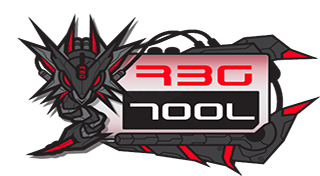

In [ ]:
# @title ❤️🧡💛💚💙💜🤎🖤🤍❤️🧡💛💚💙💜🤎🖤🤍❤️🧡💛💚💙💜🤎🖤🤍❤️🧡💛💚💙💜🤎🖤🤍❤️🧡💛💚💙💜🤎🖤🤍❤️🧡💛💚💙💜🤎🖤🤍❤️🧡💛💚💙💜🤎🖤
# @title  { display-mode: "code" }
# @title  { display-mode: "form" }
# prompt: mostrar titulo con la fuente family inherit en un  banner flotante

import ipywidgets as widgets
title = widgets.HTML(value='<h2 style="position: fixed; top: 0; left: 0; width: 100%; background-color: #000; color: #fff; font-family: inherit; font-size: 60px; text-align: center;"># Interactive Stable Diffusion 0.3.0</h2>', layout=widgets.Layout(height='40px'))
display(title)

!pip install ipywidgets
from ipywidgets import HTML
html = HTML("""
<style>

h2 {
  font-family: inherit;
  font-size:16px;
  text-shadow: 0px 2px 4px black;
  opacity: .99;
  background-image:
    url(https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Rainbow-gradient-fully-saturated.svg/512px-Rainbow-gradient-fully-saturated.svg.png);
  -webkit-background-clip: text;
  -webkit-text-fill-color: transparent;
  animation: move 160s linear infinite;
}

@keyframes move {
  to {
    background-position: 4500vh;
  }
}

body, html {
    height: 100%;
}

main, body {
            background-image: url(https://i.lcpdfrusercontent.com/uploads/monthly_2019_05/UnlinedEcstaticAnura-max-1mb.thumb.gif.8d5a654e8fa73d8432f04d9b2353a153.gif);
            background-position: 0, center;
            backdrop-filter: blur(40px);
            background-repeat: no-repeat;
            background-attachment: fixed;
            background-size: cover, auto;
            width: 100%;
            height: 400%;
            color: transparent;
            font-weight
}

</style>
""")
display(html)


HTML(value='<h2 style="position: fixed; top: 0; left: 0; width: 100%; background-color: #000; color: #fff; fon…

HTML(value='\n<style>\n\nh2 {\n  font-family: inherit;\n  font-size:16px;\n  text-shadow: 0px 2px 4px black;\n…

In [ ]:
# @title <font color='yellow'><b>Acelerar Colab</b></font> 🚀

%%capture

!kill -9 $(pgrep chrome)

!sudo rm -rf /content/.cache

!rm -rf ~/.cache/tensorflow

!rm -rf /content/.cache

!curl ipinfo.io

!gcloud config set compute/region us-central1

| Description | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/R3gm/SD_diffusers_interactive?style=social)](https://github.com/R3gm/SD_diffusers_interactive) |


- <font color=blue><b>Style</b></font> <font color=yellow><b>prompts</b></font>
- <font color=rainbow><b>Image to Image
- Hires fix
- Support for long prompts (Set `Syntax weight` in `Classic` with SD 1.5 models)
- T2I Adapter for SDXL
- FreeU for all tasks
- More embeddings
- For better performance, disable the progress bar in settings.
- Adetailer
- Prompt weights: Depending on model and CFG you can weight up to around 1.5 or 1.6 before things start to get weird.
- Controlnet 1.1 for SD
- More functions, more bugs; less than 10 words, more laughs

Previous version of the Interactive Stable Diffusion: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/R3gm/SD_diffusers_interactive/blob/e8f57e018488a0cfd3c941f56571e4cbe087a819/Stable_diffusion_interactive_notebook.ipynb)



This Google Colab notebook offers a user-friendly interface for generating AI images from text prompts using Stable Diffusion. It uses [Stablepy](https://github.com/R3gm/stablepy) and Jupyter widgets, providing a simple and lightweight alternative to web-based tools, making it accessible for all to `get started with Stable Diffusion`. With Stablepy, you can smoothly apply stable diffusion in Python, enabling seamless integration with any interface.

GUI Based on [redromnon's repository](https://github.com/redromnon/stable-diffusion-interactive-notebook)

In [ ]:
# @title <b><font color="yellow">Color Picker</font></b>
from ipywidgets import ColorPicker
color_picker = ColorPicker()
display(color_picker)

ColorPicker(value='black')

In [2]:
#@title 1. Installing dependencies

%%capture

# Para TensorFlow
!pip install tensorflow-gpu

# Para PyTorch
!pip install torch torchvision torchaudio

!pip install -q git+https://github.com/R3gm/stablepy.git@v0.3.1
!apt -y install -qq aria2

In [2]:
#@title 2. Download Checkpoints, VAEs, LoRAs `each url separated by a comma`: Please provide links for the Civitai API, Google Drive, or Hugging Face. { form-width: "20%", display-mode: "form" }

import os
%cd /content

def download_things(directory, url, hf_token=""):
    url = url.strip()

    if "drive.google.com" in url:
        original_dir = os.getcwd()
        os.chdir(directory)
        !gdown --fuzzy {url}
        os.chdir(original_dir)
    elif "huggingface.co" in url:
        if "/blob/" in url:
            url = url.replace("/blob/", "/resolve/")
        user_header = f'"Authorization: Bearer {hf_token}"'
        !aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 {url} -d {directory}  -o {url.split('/')[-1]}
    else:
        !aria2c --console-log-level=error --summary-interval=10 -c -x 16 -k 1M -s 16 -d {directory} {url}

def get_model_list(directory_path):
    model_list = []
    valid_extensions = {'.ckpt' , '.pt', '.pth', '.safetensors', '.bin'}

    for filename in os.listdir(directory_path):
        if os.path.splitext(filename)[1] in valid_extensions:
            name_without_extension = os.path.splitext(filename)[0]
            file_path = os.path.join(directory_path, filename)
            model_list.append((name_without_extension, file_path))
            print('\033[34mFILE: ' + file_path + '\033[0m')
    return model_list

def process_string(input_string):
    parts = input_string.split('/')

    if len(parts) == 2:
        first_element = parts[1]
        complete_string = input_string
        result = (first_element, complete_string)
        return result
    else:
        return None

directory_models = 'models'
os.makedirs(directory_models, exist_ok=True)
directory_loras = 'loras'
os.makedirs(directory_loras, exist_ok=True)
directory_vaes = 'vaes'
os.makedirs(directory_vaes, exist_ok=True)

#@markdown ---
#@markdown - **Download SD 1.5 Models**
download_model = "https://civitai.com/api/download/models/46846?type=Model&format=SafeTensor&size=full&fp=fp32" # @param {type:"string"}
#@markdown - **Download VAEs**
download_vae = "https://huggingface.co/Linaqruf/anything-v3.0/blob/main/anything-v3-fp32-pruned.safetensors" # @param {type:"string"}
#@markdown - **Download LoRAs**
download_lora = "https://civitai.com/api/download/models/97655, https://civitai.com/api/download/models/124358" # @param {type:"string"}
#@markdown ---
#@markdown - For SDXL models, only diffuser format models are supported, and you only need the repository name `user/repo_name`. You can find some compatible XL models [here](https://huggingface.co/models?search=-xl-fp16). Only one model is allowed here.
load_diffusers_format_model = 'SG161222/RealVisXL_V2.0' # @param {type:"string"}
#@markdown ---
#@markdown **HF TOKEN** - If you need to download your private model from Hugging Face, input your token here.
hf_token = ""  # @param {type:"string"}
#@markdown
#@markdown ---

# Download stuffs
for url in [url.strip() for url in download_model.split(',')]:
    if not os.path.exists(f"./models/{url.split('/')[-1]}"):
        download_things(directory_models, url, hf_token)
for url in [url.strip() for url in download_vae.split(',')]:
    if not os.path.exists(f"./vaes/{url.split('/')[-1]}"):
        download_things(directory_vaes, url, hf_token)
for url in [url.strip() for url in download_lora.split(',')]:
    if not os.path.exists(f"./loras/{url.split('/')[-1]}"):
        download_things(directory_loras, url, hf_token)

# Download Embeddings
directory_embeds = 'embedings'
os.makedirs(directory_embeds, exist_ok=True)
download_embeds = [
    'https://huggingface.co/datasets/Nerfgun3/bad_prompt/resolve/main/bad_prompt.pt',
    'https://huggingface.co/datasets/Nerfgun3/bad_prompt/blob/main/bad_prompt_version2.pt',
    'https://huggingface.co/embed/EasyNegative/resolve/main/EasyNegative.safetensors',
    'https://huggingface.co/embed/negative/resolve/main/EasyNegativeV2.safetensors',
    'https://huggingface.co/embed/negative/resolve/main/bad-hands-5.pt',
    'https://huggingface.co/embed/negative/resolve/main/bad-artist.pt',
    'https://huggingface.co/embed/negative/resolve/main/ng_deepnegative_v1_75t.pt',
    'https://huggingface.co/embed/negative/resolve/main/bad-artist-anime.pt',
    'https://huggingface.co/embed/negative/resolve/main/bad-image-v2-39000.pt',
    'https://huggingface.co/embed/negative/resolve/main/verybadimagenegative_v1.3.pt',
    ]

for url_embed in download_embeds:
    if not os.path.exists(f"./embedings/{url_embed.split('/')[-1]}"):
        download_things(directory_embeds, url_embed, hf_token)

# Build list models
embed_list = get_model_list(directory_embeds)
model_list = get_model_list(directory_models)
if load_diffusers_format_model.strip() != "" and load_diffusers_format_model.count('/') == 1:
    model_list.append(process_string(load_diffusers_format_model))
lora_model_list = get_model_list(directory_loras)
lora_model_list.insert(0, ("None",None))
vae_model_list = get_model_list(directory_vaes)
vae_model_list.insert(0, ("None", None))

print('\033[33m🏁 Download and listing of valid models completed.\033[0m')

from stablepy import Model_Diffusers, CONTROLNET_MODEL_IDS, UpscalerESRGAN
from stablepy.diffusers_vanilla.inpainting_canvas import draw
from stablepy.diffusers_vanilla.adetailer import ad_model_process
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy.diffusers_vanilla.model import scheduler_names
from stablepy.diffusers_vanilla.style_prompt_config import STYLE_NAMES
import torch

upscaler_dict_gui = {
    None : None,
    "Lanczos" : "Lanczos",
    "Nearest" : "Nearest",
    "RealESRGAN_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth",
    "RealESRNet_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.1/RealESRNet_x4plus.pth",
    "RealESRGAN_x4plus_anime_6B": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth",
    "RealESRGAN_x2plus": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth",
    "realesr-animevideov3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-animevideov3.pth",
    "realesr-general-x4v3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth",
    "realesr-general-wdn-x4v3" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-wdn-x4v3.pth",
    "4x-UltraSharp" : "https://huggingface.co/Shandypur/ESRGAN-4x-UltraSharp/resolve/main/4x-UltraSharp.pth",
    "4x_foolhardy_Remacri" : "https://huggingface.co/FacehugmanIII/4x_foolhardy_Remacri/resolve/main/4x_foolhardy_Remacri.pth",
    "Remacri4xExtraSmoother" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/Remacri%204x%20ExtraSmoother.pth",
    "AnimeSharp4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/AnimeSharp%204x.pth",
    "lollypop" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/lollypop.pth",
    "RealisticRescaler4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/RealisticRescaler%204x.pth",
    "NickelbackFS4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/NickelbackFS%204x.pth"
}

import re

def extract_parameters(input_string):
    parameters = {}
    input_string = input_string.replace("\n", "")

    if not "Negative prompt:" in input_string:
        print("Negative prompt not detected")
        parameters["prompt"] = input_string
        return parameters

    parm = input_string.split("Negative prompt:")
    parameters["prompt"] = parm[0]
    if not "Steps:" in parm[1]:
        print("Steps not detected")
        parameters["neg_prompt"] = parm[1]
        return parameters
    parm = parm[1].split("Steps:")
    parameters["neg_prompt"] = parm[0]
    input_string = "Steps:" + parm[1]

    # Extracting Steps
    steps_match = re.search(r'Steps: (\d+)', input_string)
    if steps_match:
        parameters['Steps'] = int(steps_match.group(1))

    # Extracting Size
    size_match = re.search(r'Size: (\d+x\d+)', input_string)
    if size_match:
        parameters['Size'] = size_match.group(1)
        width, height = map(int, parameters['Size'].split('x'))
        parameters['width'] = width
        parameters['height'] = height

    # Extracting other parameters
    other_parameters = re.findall(r'(\w+): (.*?)(?=, \w+|$)', input_string)
    for param in other_parameters:
        parameters[param[0]] = param[1].strip('"')

    return parameters

/content
 *** Download Progress Summary as of Mon Dec 25 22:20:57 2023 *** 
=
[#ef02a3 1.4GiB/5.1GiB(28%) CN:16 DL:161MiB ETA:23s]
FILE: models/revAnimated_v122EOL.safetensors
-

 *** Download Progress Summary as of Mon Dec 25 22:21:07 2023 *** 
=
[#ef02a3 2.4GiB/5.1GiB(46%) CN:16 DL:102MiB ETA:27s]
FILE: models/revAnimated_v122EOL.safetensors
-

 *** Download Progress Summary as of Mon Dec 25 22:21:18 2023 *** 
=
[#ef02a3 3.2GiB/5.1GiB(63%) CN:16 DL:85MiB ETA:22s]
FILE: models/revAnimated_v122EOL.safetensors
-

 *** Download Progress Summary as of Mon Dec 25 22:21:29 2023 *** 
=
[#ef02a3 4.4GiB/5.1GiB(87%) CN:16 DL:106MiB ETA:6s]
FILE: models/revAnimated_v122EOL.safetensors
-


Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
ef02a3|OK  |   110MiB/s|models/revAnimated_v122EOL.safetensors

Status Legend:
(OK):download completed.
 *** Download Progress Summary as of Mon Dec 25 22:21:47 2023 *** 
=
[#b70b04

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

<font color=yellow><b>--------------------------------------------------------------------------------------------</b></font>
<font color=pink><b>--------------------------------------------------------------------------------------------</b></font>
<font color=blue><b>--------------------------------------------------------------------------------------------</b></font>
<font color=red><b>--------------------------------------------------------------------------------------------</b></font>

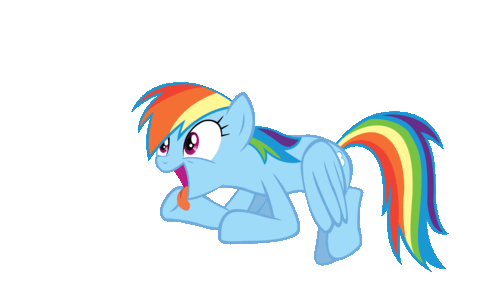

---
- <font color=blue>**Prompt**</font> - <font color=green><b>Tell the model what you want to see.</b></font>
- <font color=rainbow><b>**Negative Prompt** - Tell the model what you don't want to see.
- **Steps** - How long the model should work on the image.
- **CFG** - Controls how much the image generation process follows the text prompt.  Guidance scale ranging from 0 to 20. Lower values allow the AI to be more creative and less strict at following the prompt. Default is 7.5
- **Sampler** - Progressively reduce image noise through denoising steps.
- **Seed** -  A number that helps the model start generating the image. Set `-1` for using random seed values.
- **Clip Skip** - It allows to control the level of detail and accuracy in the generated images by skipping certain layers of the CLIP model during the image generation process.
- **Prompt weights** -  Helps the model focus on different parts of the prompt. Prompt weights can be used to emphasize or de-emphasize certain aspects of the image, such as the object, the scene, or the style. Currently, the [Compel syntax](https://github.com/damian0815/compel/blob/main/doc/syntax.md) is being used corresponding to `(word)1.1` or `(word)+`. The other type of syntax is the `Classic`, it uses the format `(word:1.1)` or `(word)`. This option can be changed using the `Prompt syntax` dropdown.
- **Long prompts** - This is a method for managing lengthy prompts that enables the use of unlimited characters in prompts. Currently, this feature can be activated under Prompt syntax in Classic, exclusively with SD 1.5 models.
- **Embeddings** - Help the model to adapt to a particular style.
- **FreeU** - Is a method that substantially improves diffusion model sample quality at no costs.
- **VAE** - Each model has a default VAE, but we can change it for another one to obtain different results. During inference, the VAE decoder is responsible for converting the denoised image (latent space) into images.
- **ControlNet** - Enhances text-to-image diffusion models by allowing various spatial contexts to serve as additional conditioning, enabling the generation of more controlled and context-aware images. The right column contains all the specific ControlNet options.
- **Inpaint** - Is a technique for filling parts of an image by using a diffusion model to generate new pixels based on the surrounding pixels. It can be used to repair damaged photos, remove unwanted objects from images, and even create new images by combining multiple images. To use this option more easily, use the cell 'Upload an image here for use in Inpainting or ControlNet', check 'Create_mask_for_Inpaint,' and run the cell to upload an image to create a mask of the image with the mouse.
- **Adetailer** - Adetailer automates inpainting and fixing common issues. It is advisable to set "Inpaint strength" to values lower than 0.4 for better results.
- **LCM** - Latent Consistency Models (LCM) can generate images in a few steps. When selecting the 'LCM' sampler, the model automatically loads the LCM_LoRA for the task. Generally, guidance_scale is used at 1.0 or a maximum of 2.0, with steps between 4 and 8
- **img2img** - Is a feature that allows you to modify an existing image based on a text prompt. This means that you can take an image and use the model to change its style, content, or composition.
- **Styles** - These are additions to the prompt and negative prompt to utilize a specific style in generation.
- **High-resolution** - It allows you to proportionally increase the size of your images and correct some imperfections in them.
- 🎲 - Set a random seed.
- ↙️ - It allows you to use Generation Data and set the parameters in the GUI, currently only available for some specific parameters.
- 🗑️ - Clear prompt and negative prompt.
---

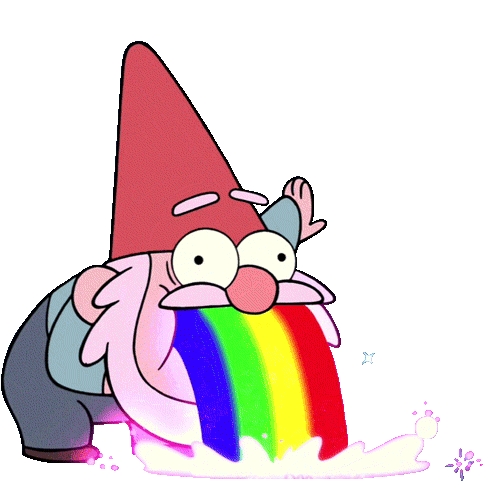

In [ ]:
# @title GPU ANTI DISCONECT 60s infinite
import time

while True:
    # Realiza alguna operación que consuma tiempo
    time.sleep(60)  # Espera 60 segundos antes de la siguiente iteración

KeyboardInterrupt: ignored

In [3]:
#@title 3. <h2>★GUI★</h2> { form-width: "20%", display-mode: "form" }

save_and_load_config = True #@param {type:"boolean"}

%cd /content
from google.colab import output
output.disable_custom_widget_manager()
# GUI
import ipywidgets as widgets, mediapy, random
from PIL import Image
import IPython.display
import time, json
from IPython.utils import capture
import logging
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, BoundedFloatText
logging.getLogger("diffusers").setLevel(logging.ERROR)
import diffusers
diffusers.utils.logging.set_verbosity(40)
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning, module="diffusers")
warnings.filterwarnings(action="ignore", category=UserWarning, module="diffusers")
warnings.filterwarnings(action="ignore", category=FutureWarning, module="transformers")
#logging.getLogger("transformers").setLevel(logging.ERROR)
#logging.getLogger("transformers").addFilter(lambda record: '`text_config_dict`' not in record.getMessage())

from stablepy import logger
logger.setLevel(logging.INFO)
#from IPython.display import display
from ipywidgets import TwoByTwoLayout, Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider, interactive, HBox, VBox, BoundedIntText, BoundedFloatText
import gc
import base64

def make_string_fancy(text):
    fancy_string = base64.b64encode(text.encode()).decode()
    return fancy_string

def make_string_normal(fancy_text):
    normal_string = base64.b64decode(fancy_text).decode()
    return normal_string

#PARAMETER WIDGETS
width = "225px"
width_up = "300px"
auto_layout = widgets.Layout(height='auto', width='auto')
lora_layout = {'width':'165px'}
lora_scale_layout = {'width':'50px'}
style = {'description_width': 'initial'} # show full text

control_model_list = list(CONTROLNET_MODEL_IDS.keys())

# =====================================
# Left
# =====================================

num_images = widgets.BoundedIntText(
    value = 1,
    min = 1,
    description="Images:",
    layout=widgets.Layout(width=width)
)

steps = widgets.BoundedIntText(
    value = 150,
    min = 0,
    max = 300,
    description="Steps:",
    layout=widgets.Layout(width=width)
)

CFG = widgets.BoundedFloatText(
    value = 11,
    min = 0,
    step=0.5,
    description="CFG:",
    layout=widgets.Layout(width=width)
)

select_sampler = widgets.Dropdown(
    options=scheduler_names,
    description="Sampler:",
    layout=widgets.Layout(width=width),
)

img_height = widgets.BoundedIntText(
    min=64,
    max=4096,
    step=8,
    value=648,
    description="Height:",
    layout=widgets.Layout(width=width),
)

img_width = widgets.BoundedIntText(
    min=64,
    max=4096,
    step=8,
    value=648,
    description="Width:",
    layout=widgets.Layout(width=width),
)

random_seed = widgets.IntText(
    value=-1,
    description="Seed:",
    layout=widgets.Layout(width="195px"),
    disabled=False
)

random_seed_button = widgets.Button(
    description="🎲",
    disabled=False,
    #button_style="primary",
    layout=widgets.Layout(width="20px"),
    style = style,
)
random_seed_button.style.button_color = '#a50000'

def set_random_seed_button(value):
    random_seed.value = -1
    return

random_seed_button.on_click(set_random_seed_button)

#lora1
select_lora1 = widgets.Dropdown(
    options=lora_model_list,
    description="Lora1:",
    layout=lora_layout
)

lora_weights_scale1 = widgets.FloatText(
    min=-2.0,
    max=2.0,
    step=0.01,
    value=1,
    #description="Lora scale1:",
    layout=lora_scale_layout
)
#lora2
select_lora2 = widgets.Dropdown(
    options=lora_model_list,
    description="Lora2:",
    layout=lora_layout
)

lora_weights_scale2 = widgets.FloatText(
    min=-2.0,
    max=2.0,
    step=0.01,
    value=1,
    #description="Lora scale2:",
    layout=lora_scale_layout
)
#lora3
select_lora3 = widgets.Dropdown(
    options=lora_model_list,
    description="Lora3:",
    layout=lora_layout
)

lora_weights_scale3 = widgets.FloatText(
    min=-2.0,
    max=2.0,
    step=0.01,
    value=1,
    #description="Lora scale3:",
    layout=lora_scale_layout
)
#lora4
select_lora4 = widgets.Dropdown(
    options=lora_model_list,
    description="Lora4:",
    layout=lora_layout
)

lora_weights_scale4 = widgets.FloatText(
    min=-2.0,
    max=2.0,
    step=0.01,
    value=1,
    #description="Lora scale4:",
    layout=lora_scale_layout
)
#lora5
select_lora5 = widgets.Dropdown(
    options=lora_model_list,
    description="Lora5:",
    layout=lora_layout
)

lora_weights_scale5 = widgets.FloatText(
    min=-2.0,
    max=2.0,
    step=0.01,
    value=1,
    #description="Lora scale5:",
    layout=lora_scale_layout
)

select_clip_skip = widgets.Checkbox(
    value=True,
    description='Layer 2 Clip Skip',
    layout=widgets.Layout(width=width),
)

freeu_check = widgets.Checkbox(
    value=True,
    description='FreeU',
    layout=widgets.Layout(width=width),
)

# =====================================
# Center
# =====================================

display_imgs = widgets.Output() # layout={'border': '1px solid black'}

select_model = widgets.Dropdown(
    options=model_list,
    description="Model:",
    layout=auto_layout,
)

vae_model_dropdown = widgets.Dropdown(
    options=vae_model_list,
    description="VAE:",
    layout=auto_layout,
)

prompt = widgets.Textarea(
    value="",
    placeholder="Enter prompt",
    rows=5,
    layout=auto_layout,
)

neg_prompt = widgets.Textarea(
    value="verybadimagenegative_v1.3, ng_deepnegative_v1_75t, (ugly face:0.8),cross-eyed,sketches, (worst quality:2), (low quality:2), (normal quality:2), lowres, normal quality, ((monochrome)), ((grayscale)), skin spots, acnes, skin blemishes, bad anatomy, DeepNegative, facing away, tilted head, {Multiple people}, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worstquality, low quality, normal quality, jpegartifacts, signature, watermark, username, blurry, bad feet, cropped, poorly drawn hands, poorly drawn face, mutation, deformed, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, extra fingers, fewer digits, extra limbs, extra arms,extra legs, malformed limbs, fused fingers, too many fingers, long neck, cross-eyed,mutated hands, polar lowres, bad body, bad proportions, gross proportions, text, error, missing fingers, missing arms, missing legs, extra digit, extra arms, extra leg, extra foot, ((repeating hair))",
    placeholder="Enter negative prompt",
    rows=5,
    layout=auto_layout,
)

extract_params_button = widgets.Button(
    description="↙️",
    disabled=False,
    #button_style="primary",
    layout=widgets.Layout(width="40px"),
    style = style,
)
extract_params_button.style.button_color = '#a50000'


valid_receptors = {
    "prompt": prompt,
    "neg_prompt": neg_prompt,
    "Steps": steps,
    "width": img_width,
    "height": img_height,
    "Seed": random_seed,
    "Sampler": select_sampler,
    "scale": CFG, # cfg
    "skip": select_clip_skip,
}
valid_keys = list(valid_receptors.keys())

def set_params_in_ui(value):
  with display_imgs:
    parameters = extract_parameters(prompt.value)
    for key, val in parameters.items():
        if key in valid_keys:
            if key == "Sampler":
              if val not in scheduler_names:
                  continue
            elif key == "skip":
              if int(val) >= 2:
                val = True
            if key == "prompt":
              if ">" in val and "<" in val:
                val = re.sub(r'<[^>]+>', '', val)
                print("Removed LoRA written in the prompt")
            valid_receptors[key].value = val
    return

extract_params_button.on_click(set_params_in_ui)

delete_params_button = widgets.Button(
    description="🗑️",
    disabled=False,
    #button_style="primary",
    layout=widgets.Layout(width="40px"),
    style = style,
)
delete_params_button.style.button_color = '#a50000'

def delete_params_in_ui(value):
    prompt.value = ""
    neg_prompt.value = ""
    return

delete_params_button.on_click(delete_params_in_ui)

active_ti = widgets.Checkbox(
    value=False,
    description='Active Textual Inversion in prompt',
    #style = style,
    layout=auto_layout,
)
# alternative prompt weights
weights_prompt = widgets.Dropdown(
    options=[("Compel (default) format: (word)weight", "Compel"), ("Classic (sd1.5 long prompts) format: (word:weight)", "Classic")],
    description='Prompt syntax',
    style = style,
    layout=auto_layout,
)

generate = widgets.Button(
    description="Generate",
    disabled=False,
    button_style="primary",
    layout=Layout(height='auto', width='auto'),
    style = {'font_weight': 'bold'}
)

### GENERATE ###
count_runs = 0
def generate_img(i):
  global model
  #Clear output
  display_imgs.clear_output()
  generate.disabled = True

  with display_imgs:

    print("Loading model...")


    # First load
    try:
        model
    except:
        model = Model_Diffusers(base_model_id=select_model.value, task_name=select_task.value, vae_model = vae_model_dropdown.value, type_model_precision = model_precision.value)

    model.load_pipe(select_model.value, task_name=select_task.value, vae_model = vae_model_dropdown.value, type_model_precision = model_precision.value)

    display_imgs.clear_output()

    try:
      preprocessor_name_found = int_inputs[select_task.value][0].value
    except:
      preprocessor_name_found = None

    global destination_path_cn_img, mask_control, image_list, count_runs, save_and_load_config

    image_control_base = None
    if select_task.value != control_model_list[13]:
        try:
            image_control_base = destination_path_cn_img
        except:
            print("No control image found: To use this function, you have to upload an image in the cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️' first 👇")
            generate.disabled = False
            return

    mask_control_base = None
    if select_task.value == control_model_list[12]:
        if os.path.exists(int_inputs[control_model_list[12]][1].value):
            mask_control_base = int_inputs[control_model_list[12]][1].value
        else:
            try:
                mask_control_base = mask_control
            except:
                print("No mask image found: Specify a path in the GUI or create one using cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️'")
                generate.disabled = False
                return


    if upscaler_model_path_gui.value in [None, "Lanczos", "Nearest"]:
        upscaler_model = upscaler_model_path_gui.value
    else:
        directory_upscalers = 'upscalers'
        os.makedirs(directory_upscalers, exist_ok=True)

        url_upscaler = upscaler_dict_gui[upscaler_model_path_gui.value]

        if not os.path.exists(f"./upscalers/{url_upscaler.split('/')[-1]}"):
            download_things(directory_upscalers, url_upscaler, hf_token)

        upscaler_model = f"./upscalers/{url_upscaler.split('/')[-1]}"

    if active_ti.value == True and model.class_name == "StableDiffusionXLPipeline":
        print("No Textual inversion for SDXL")

    logging.getLogger("ultralytics").setLevel(logging.INFO if adetailer_verbose.value else logging.ERROR)

    count_runs += 1
    if count_runs%11 == 0 and count_runs != 0:
        print("🖱️ Keep in mind to occasionally make use of other cells, such as 'Codeformer', to prevent any inconvenience from disconnection due to inactivity.")

    adetailer_params_A = {
        "face_detector_ad" : face_detector_ad_A.value,
        "person_detector_ad" : person_detector_ad_A.value,
        "hand_detector_ad" : hand_detector_ad_A.value,
        "prompt": prompt_ad_A.value,
        "negative_prompt" : negative_prompt_ad_A.value,
        "strength" : strength_ad_A.value,
        # "image_list_task" : None,
        "mask_dilation" : mask_dilation_A.value,
        "mask_blur" : mask_blur_A.value,
        "mask_padding" : mask_padding_A.value,
        "inpaint_only" : adetailer_inpaint_only.value,
        "sampler" : adetailer_sampler.value,
    }

    adetailer_params_B = {
        "face_detector_ad" : face_detector_ad_B.value,
        "person_detector_ad" : person_detector_ad_B.value,
        "hand_detector_ad" : hand_detector_ad_B.value,
        "prompt": prompt_ad_B.value,
        "negative_prompt" : negative_prompt_ad_B.value,
        "strength" : strength_ad_B.value,
        # "image_list_task" : None,
        "mask_dilation" : mask_dilation_B.value,
        "mask_blur" : mask_blur_B.value,
        "mask_padding" : mask_padding_B.value,
    }
    pipe_params = {
    "prompt": prompt.value,
    "negative_prompt": neg_prompt.value,
    "img_height": img_height.value,
    "img_width": img_width.value,
    "num_images": num_images.value,
    "num_steps": steps.value,
    "guidance_scale": CFG.value,
    "clip_skip": select_clip_skip.value,
    "seed": random_seed.value,
    "image": image_control_base,
    "preprocessor_name": preprocessor_name_found,
    "preprocess_resolution": preprocess_resolution_global.value,
    "image_resolution": image_resolution_global.value,
    "style_prompt": style_names_multi_selection.value,
    "style_json_file" : "",
    "image_mask": mask_control_base, # only for Inpaint
    "strength": int_inputs[control_model_list[12]][0].value, # only for Inpaint
    "low_threshold": int_inputs[control_model_list[1]][0].value,
    "high_threshold": int_inputs[control_model_list[1]][1].value,
    "value_threshold": int_inputs[control_model_list[2]][0].value,
    "distance_threshold": int_inputs[control_model_list[2]][1].value,
    "lora_A": select_lora1.value,
    "lora_scale_A": lora_weights_scale1.value,
    "lora_B": select_lora2.value,
    "lora_scale_B": lora_weights_scale2.value,
    "lora_C": select_lora3.value,
    "lora_scale_C": lora_weights_scale3.value,
    "lora_D": select_lora4.value,
    "lora_scale_D": lora_weights_scale4.value,
    "lora_E": select_lora5.value,
    "lora_scale_E": lora_weights_scale5.value,
    "textual_inversion": embed_list if active_ti.value and model.class_name != "StableDiffusionXLPipeline" else [],
    "syntax_weights" : weights_prompt.value, #"Classic" , #"convert_weights_prompt": weights_prompt.value,
    "sampler": select_sampler.value,
    "xformers_memory_efficient_attention": xformers_memory_efficient_attention.value,
    "gui_active": True,
    "loop_generation": loop_generator.value,
    "controlnet_conditioning_scale" : controlnet_output_scaling_in_unet.value,
    "control_guidance_start" : controlnet_start_threshold.value,
    "control_guidance_end" : controlnet_stop_threshold.value,
    "generator_in_cpu" : init_generator_in_cpu.value,
    "FreeU" : freeu_check.value,
    "adetailer_A" : adetailer_active_A.value,
    "adetailer_A_params" : adetailer_params_A,
    "adetailer_B" : adetailer_active_B.value,
    "adetailer_B_params" : adetailer_params_B,
    "leave_progress_bar" : True,
    "disable_progress_bar" : disable_progress_bar_check.value,
    "image_previews" : False,
    "display_images" : display_images.value,
    "save_generated_images" : save_generated_images.value,
    "image_storage_location" : image_directory.value,
    "retain_compel_previous_load" : retain_compel_previous_load.value,
    "retain_detailfix_model_previous_load": retain_detailfix_model_previous_load.value,
    "retain_hires_model_previous_load": retain_hires_model_previous_load.value,
    "t2i_adapter_preprocessor" : t2i_adapter_preprocessor_check.value,
    "t2i_adapter_conditioning_scale" : adapter_conditioning_scale_scale.value,
    "t2i_adapter_conditioning_factor" : adapter_conditioning_factor_fraction.value,
    "upscaler_model_path" : upscaler_model,
    "upscaler_increases_size" : upscaler_increases_size.value,
    "esrgan_tile" : esrgan_tile.value,
    "esrgan_tile_overlap" : esrgan_tile_overlap.value,
    "hires_steps" : hires_steps.value,
    "hires_denoising_strength" : hires_denoising_strength.value,
    "hires_prompt" : hires_prompt.value,
    "hires_negative_prompt" : hires_negative_prompt.value,
    "hires_sampler" : hires_sampler.value,
    "hires_before_adetailer" : hires_before_adetailer.value,
    "hires_after_adetailer" : hires_after_adetailer.value
    }

    if show_params.value:
        print(pipe_params)

    images, image_list = model(**pipe_params)
    generate.disabled = False
    # if loop_generator.value == 1:
    #     mediapy.show_images(images)

    if save_and_load_config:
        # save config
        file_path = 'config_load.json'

        pipe_params["select_model"] = select_model.label
        pipe_params["task_name"] = select_task.label
        pipe_params["vae_model"] = vae_model_dropdown.label
        pipe_params["type_model_precision"] = model_precision.label
        pipe_params["upscaler_model_path"] = upscaler_model_path_gui.label
        pipe_params["prompt"] = make_string_fancy(pipe_params["prompt"])
        pipe_params["negative_prompt"] = make_string_fancy(pipe_params["negative_prompt"])
        pipe_params["textual_inversion"] = active_ti.value
        pipe_params.pop("adetailer_A_params", None)
        pipe_params.pop("adetailer_B_params", None)
        pipe_params["hires_prompt"] = make_string_fancy(pipe_params["hires_prompt"])
        pipe_params["hires_negative_prompt"] = make_string_fancy(pipe_params["hires_negative_prompt"])
        with open(file_path, 'w') as json_file:
            json.dump(pipe_params, json_file, indent=2)

    torch.cuda.empty_cache()
    gc.collect()
    display(clear_outputs)

  generate.disabled = False
  return

generate.on_click(generate_img)

show_textual_inversion = widgets.Button(
    description="List available textual inversions",
    disabled=False,
    button_style="info",
    layout=widgets.Layout(height='auto', width='auto'),
)

def elemets_textual_inversion(value):
  with display_imgs:
    print('Write the word in the prompt for use and "Active Textual Inversion in the prompt"')
    print('The currently supported embeddings are as follows:')
    for name, directory_name in embed_list:
        print(f'\033[34m {name} \033[0m')
    return

show_textual_inversion.on_click(elemets_textual_inversion)

clear_outputs = widgets.Button(
    description="Clear outputs",
    disabled=False,
    button_style="info",
    layout=widgets.Layout(height='auto', width='auto'),

)

def clear_outputs_run(value):
  display_imgs.clear_output()
  return

clear_outputs.on_click(clear_outputs_run)

t2i_description = widgets.Label(
    value="T2i adapter will also take the 'Image resolution' and 'Preprocessor resolution'.",
    layout=Layout(visibility='hidden',height='auto', width='auto'),
    style=style
)

t2i_adapter_preprocessor_check = widgets.Checkbox(
    value=True,
    description='T2i-adapter preprocessor',
    layout=Layout(visibility='hidden', width=width),
    style=style
)

adapter_conditioning_scale_scale = widgets.FloatText(
    value=1.0,
    min=0.0,
    max=5.0,
    step=0.1,
    description='Scale adapter outputs in UNet:',
    layout=Layout(visibility='hidden', width=width),
    style=style
)

adapter_conditioning_factor_fraction = widgets.BoundedFloatText(
    value=0.55,
    min=0.00,
    max=1.0,
    step=0.01,
    description='Limit adapter application (%):',
    layout=Layout(visibility='hidden', width=width),
    style=style
)

# =====================================
# Right ControlNet
# =====================================

control_model_list = list(CONTROLNET_MODEL_IDS.keys())

# Create a Dropdown for selecting options
select_task = widgets.Dropdown( #
    options=[
        control_model_list[13],
        control_model_list[12],
        control_model_list[19],
        control_model_list[0],
        control_model_list[1],
        control_model_list[2],
        control_model_list[3],
        control_model_list[4],
        control_model_list[5],
        control_model_list[6],
        control_model_list[7],
        control_model_list[8],
        control_model_list[10],
        control_model_list[11],
        control_model_list[14],
        control_model_list[15],
        control_model_list[16],
        control_model_list[17],
        control_model_list[18],
    ],
    description='TASK:',
    layout=auto_layout,
)

controlnet_output_scaling_in_unet = widgets.FloatText(
    value=1.0,
    min=0.0,
    max=5.0,
    step=0.1,
    description='ControlNet Output Scaling in UNet:',
    style=style
)

controlnet_start_threshold = widgets.FloatSlider(
    value=0.0,
    min=0.00,
    max=1.0,
    step=0.01,
    description='ControlNet Start Threshold (%):',
    style=style
)

controlnet_stop_threshold = widgets.FloatSlider(
    value=1.0,
    min=0.00,
    max=1.0,
    step=0.01,
    description='ControlNet Stop Threshold (%):',
    style=style
)

preprocess_resolution_global = widgets.IntSlider(
    value=512,
    min=64,
    step=64,
    max=2048,
    description='Preprocessor resolution',
    style=style,
    continuous_update=True,
)

image_resolution_global = widgets.IntSlider(
    value=512,
    min=64,
    step=64,
    max=2048,
    description='Image resolution',
    style=style,
    continuous_update=True,
)

# Create a dictionary to map options to lists of IntText widgets
int_inputs = {

    control_model_list[13]: [
    ],
    control_model_list[12]: [
        widgets.FloatSlider(value=0.35, min=0.01, max=1.0, step=0.01, description='Strength:', layout=Layout(visibility='hidden'), style=style),
        widgets.Text(value="", placeholder="/content/my_mask.png", rows=1, description='Mask path:', layout=Layout(visibility='hidden'), style=style)
    ],
    control_model_list[0]: [
        widgets.Dropdown(value='Openpose', description='Preprocessor:', options=['None','Openpose'], layout=Layout(visibility='hidden'), style=style),
    ],
    control_model_list[1]: [
        widgets.BoundedIntText(value=100, min=1, max=255, description='Canny low threshold:', layout=Layout(visibility='hidden'), style=style),
        widgets.BoundedIntText(value=200, min=1, max=255, description='Canny high threshold:', layout=Layout(visibility='hidden'), style=style)
    ],
    control_model_list[2]: [
        widgets.BoundedFloatText(value=0.1, min=1, max=2.0, step=0.01, description='Hough value threshold (MLSD):', layout=Layout(visibility='hidden'), style=style),
        widgets.BoundedFloatText(value=0.1, min=1, max=20.0, step=0.01, description='Hough distance threshold (MLSD):', layout=Layout(visibility='hidden'), style=style)
    ],
    control_model_list[3]: [
        widgets.Dropdown(value='HED', description='Preprocessor:', options=['HED','PidiNet', 'None'], layout=Layout(visibility='hidden'), style=style),
    ],
    control_model_list[4]: [
        widgets.Dropdown(value='PidiNet', description='Preprocessor:', options=['HED','PidiNet', 'HED safe', 'PidiNet safe','None'], layout=Layout(visibility='hidden'), style=style),
    ],
    control_model_list[5]: [
        widgets.Dropdown(value='UPerNet', description='Preprocessor:', options=['UPerNet','None'], layout=Layout(visibility='hidden'), style=style),
    ],
    control_model_list[6]: [
        widgets.Dropdown(value='DPT', description='Preprocessor:', options=['Midas', 'DPT','None'], layout=Layout(visibility='hidden'), style=style),
    ],
    control_model_list[7]: [
        widgets.Dropdown(value='NormalBae', description='Preprocessor:', options=['NormalBae','None'], layout=Layout(visibility='hidden'), style=style),
    ],
    control_model_list[8]: [
        widgets.Dropdown(value='Lineart', description='Preprocessor:', options=['Lineart','Lineart coarse', 'None', 'Lineart (anime)', 'None (anime)'], layout=Layout(visibility='hidden'), style=style),
    ],
    control_model_list[10]: [
        widgets.Dropdown(value='ContentShuffle', description='Preprocessor:', options=['ContentShuffle','None'], layout=Layout(visibility='hidden'), style=style),
    ],
}

# Function to update visibility and enable/disable state of widgets
def update_widgets(option):
    for opt, int_inputs_list in int_inputs.items():
        if opt == option:
            for int_input in int_inputs_list:
                int_input.layout.visibility = 'visible'
        else:
            for int_input in int_inputs_list:
                int_input.layout.visibility = 'hidden'
        if option in [control_model_list[14],control_model_list[15],control_model_list[16],control_model_list[17],control_model_list[18]]:
            t2i_description.layout.visibility = "visible"
            t2i_adapter_preprocessor_check.layout.visibility = "visible"
            adapter_conditioning_scale_scale.layout.visibility = "visible"
            adapter_conditioning_factor_fraction.layout.visibility = "visible"
        else:
            t2i_description.layout.visibility = "hidden"
            t2i_adapter_preprocessor_check.layout.visibility = "hidden"
            adapter_conditioning_scale_scale.layout.visibility = "hidden"
            adapter_conditioning_factor_fraction.layout.visibility = "hidden"
    if option in [control_model_list[19], control_model_list[12]]:
        int_inputs[control_model_list[12]][0].layout.visibility = 'visible'
    else:
        int_inputs[control_model_list[12]][0].layout.visibility = "hidden"

interactive(update_widgets, option=select_task)

# =====================================
# Adetailer
# =====================================

adetailer_inpaint_only = widgets.Checkbox(
    value=True,
    description='Inpaint only',
    layout=auto_layout,
    style = style,
)

adetailer_verbose = widgets.Checkbox(
    value=False,
    description='Verbose',
    layout=auto_layout,
    style = style,
)

adetailer_sampler = widgets.Dropdown(
    options=["Use same sampler"] + scheduler_names[:-1],
    value="Use same sampler",
    description="Adetailer sampler:",
    layout=widgets.Layout(width="500px"),
    #layout=auto_layout,
    style = style,
)

# A #

adetailer_active_A =  widgets.Checkbox(
    value=False,
    description='Enable Adetailer A',
    layout=widgets.Layout(width=width),
)

prompt_ad_A = widgets.Textarea(
    value="",
    placeholder="Main prompt will be use",
    rows=3,
    layout=widgets.Layout(width=width),
)

negative_prompt_ad_A = widgets.Textarea(
    value="",
    placeholder="Main negative prompt will be use",
    rows=3,
    layout=widgets.Layout(width=width),
)

strength_ad_A = widgets.FloatSlider(
    value=0.35,
    min=0.01,
    max=1.0,
    step=0.01,
    description='Inpaint strength:',
    layout=widgets.Layout(width=width),
    style=style
)

face_detector_ad_A = widgets.Checkbox(
    value=True,
    description='Face detector',
    layout=widgets.Layout(width=width),
)

person_detector_ad_A = widgets.Checkbox(
    value=True,
    description='Person detector',
    layout=widgets.Layout(width=width),
)

hand_detector_ad_A = widgets.Checkbox(
    value=False,
    description='Hand detector',
    layout=widgets.Layout(width=width),
)

mask_dilation_A = widgets.BoundedIntText(
    value = 4,
    min = 1,
    description="Mask dilation:",
    layout=widgets.Layout(width=width)
)

mask_blur_A = widgets.BoundedIntText(
    value = 4,
    min = 1,
    description="Mask blur:",
    layout=widgets.Layout(width=width)
)

mask_padding_A = widgets.BoundedIntText(
    value = 32,
    min = 1,
    description="Mask padding:",
    layout=widgets.Layout(width=width)
)


# B #

adetailer_active_B =  widgets.Checkbox(
    value=False,
    description='Enable Adetailer B',
    layout=widgets.Layout(width=width),
)

prompt_ad_B = widgets.Textarea(
    value="",
    placeholder="Main prompt will be use",
    rows=3,
    layout=widgets.Layout(width=width),
)

negative_prompt_ad_B = widgets.Textarea(
    value="",
    placeholder="Main negative prompt will be use",
    rows=3,
    layout=widgets.Layout(width=width),
)

strength_ad_B = widgets.FloatSlider(
    value=0.35,
    min=0.01,
    max=1.0,
    step=0.01,
    description='Inpaint strength:',
    layout=widgets.Layout(width=width),
    style=style
)

face_detector_ad_B = widgets.Checkbox(
    value=True,
    description='Face detector',
    layout=widgets.Layout(width=width),
)

person_detector_ad_B = widgets.Checkbox(
    value=True,
    description='Person detector',
    layout=widgets.Layout(width=width),
)

hand_detector_ad_B = widgets.Checkbox(
    value=False,
    description='Hand detector',
    layout=widgets.Layout(width=width),
)

mask_dilation_B = widgets.BoundedIntText(
    value = 4,
    min = 1,
    description="Mask dilation:",
    layout=widgets.Layout(width=width)
)

mask_blur_B = widgets.BoundedIntText(
    value = 4,
    min = 1,
    description="Mask blur:",
    layout=widgets.Layout(width=width)
)

mask_padding_B = widgets.BoundedIntText(
    value = 32,
    min = 1,
    description="Mask padding:",
    layout=widgets.Layout(width=width)
)

# =====================================
# High-resolution
# =====================================

upscaler_keys = list(upscaler_dict_gui.keys())

upscaler_model_path_gui = widgets.Dropdown(
    options=upscaler_keys,
    description="Upscaler",
    layout=widgets.Layout(width=width_up),
    style = style,
)

upscaler_increases_size = widgets.BoundedFloatText(
    value = 2,
    min = 1.1,
    max = 6.0,
    step=0.1,
    description="Upscale by:",
    layout=widgets.Layout(width=width_up),
    style = style,
)

esrgan_tile = widgets.BoundedIntText(
    value = 100,
    min = 0,
    max = 500,
    description="ESRGAN tile:",
    layout=widgets.Layout(width=width_up),
    style = style,
)

esrgan_tile_overlap = widgets.BoundedIntText(
    value = 10,
    min = 1,
    max = 200,
    description="ESRGAN tile overlap:",
    layout=widgets.Layout(width=width_up),
    style = style,
)


hires_steps = widgets.BoundedIntText(
    value = 30,
    min = 0,
    max = 100,
    description="Hires steps:",
    layout=widgets.Layout(width=width_up),
    style = style,
)

hires_denoising_strength = widgets.BoundedFloatText(
    value = 0.55,
    min = 0.1,
    max = 1.0,
    step=0.01,
    description="Hires denoising strength:",
    layout=widgets.Layout(width=width_up),
    style = style,
)

hires_sampler = widgets.Dropdown(
    options=["Use same sampler"] + scheduler_names[:-1],
    value="Use same sampler",
    description="Hires sampler:",
    layout=widgets.Layout(width=width_up),
)

hires_prompt = widgets.Textarea(
    value="",
    placeholder="Main prompt will be use",
    rows=3,
    layout=widgets.Layout(width=width_up),
    style = style,
)

hires_negative_prompt = widgets.Textarea(
    value="",
    placeholder="Main negative prompt will be use",
    rows=3,
    layout=widgets.Layout(width=width_up),
    style = style,
)

# =====================================
# Settings
# =====================================
loop_generator = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    description='Loops 🔁',
    #layout=auto_layout,
    style = style,
)

disable_progress_bar_check = widgets.Checkbox(
    value=False,
    description='Disable progress bar',
    layout=auto_layout,
    style = style,
)

xformers_memory_efficient_attention = widgets.Checkbox(
    value=False,
    description='Xformers memory efficient attention',
    layout=auto_layout,
    style = style,
)

display_images = widgets.Checkbox(
    value=True,
    description='Display images',
    layout=auto_layout,
    style = style,
)

save_generated_images = widgets.Checkbox(
    value=True,
    description='Save images',
    layout=auto_layout,
    style = style,
)

image_directory = widgets.Text(
    value="./images",
    placeholder="/content/images",
    rows=1,
    description='Image storage directory:',
    layout=auto_layout,
    style=style
)

hires_before_adetailer = widgets.Checkbox(
    value=False,
    description='Hires before adetailer',
    layout=auto_layout,
    style = style,
)

hires_after_adetailer = widgets.Checkbox(
    value=True,
    description='Hires after adetailer',
    layout=auto_layout,
    style = style,
)

retain_compel_previous_load = widgets.Checkbox(
    value=False,
    description='Retain compel previous load',
    layout=auto_layout,
    style = style,
)

retain_detailfix_model_previous_load = widgets.Checkbox(
    value=False,
    description='Retain adetailer model previous load',
    layout=auto_layout,
    style = style,
)

retain_hires_model_previous_load = widgets.Checkbox(
    value=False,
    description='Retain hires model previous load',
    layout=auto_layout,
    style = style,
)

show_params = widgets.Checkbox(
    value=False,
    description='Display all the set parameters',
    layout=auto_layout,
    style = style,
)

model_precision = widgets.RadioButtons(
    options=[("float16", torch.float16),("float32", torch.float32)],
    description="Model precision (float32 need more memory):",
    layout=auto_layout,
    style = style,
)

init_generator_in_cpu = widgets.Checkbox(
    value=False,
    description='Generate initial random noise with the seed on the CPU',
    layout=auto_layout,
    style = style,
)

try:
    style_names_found = model.STYLE_NAMES
except:
    style_names_found = STYLE_NAMES
style_names_multi_selection = widgets.SelectMultiple(
    options=style_names_found,
    #value=['No Style'],
    rows=10,
    description='Styles',
    disabled=False
)

# =====================================
# App
# =====================================

title_tab_one = widgets.HTML(
    value="<h2 style='color: #a50000;'>SD Interactive</h2>",
    layout=widgets.Layout(display="flex", justify_content="center")
)
title_tab_adetailer = widgets.HTML(
    value="<h2 style='color: #a50000;'>Adetailer</h2>",
    layout=widgets.Layout(display="flex", justify_content="center")
)
title_tab_hires = widgets.HTML(
    value="<h2 style='color: #a50000;'>High-resolution</h2>",
    layout=widgets.Layout(display="flex", justify_content="center")
)
title_tab_settings = widgets.HTML(
    value="<h2 style='color: #a50000;'>Settings</h2>",
    layout=widgets.Layout(display="flex", justify_content="center")
)

def line_section(width):
    return widgets.HTML(f'<div style="border-bottom: dashed 1px #a50000; margin: 5px 0 5px 0; width: {width}%">')

buttons_ = TwoByTwoLayout(top_left=generate,
               top_right=show_textual_inversion,
               #bottom_left=None,
               bottom_right=clear_outputs, merge=True)

show_textual_inversion.style.button_color = '#a50000'
clear_outputs.style.button_color = '#a50000'
generate.style.button_color = '#a50000'

# TAB 1
tab_sd = widgets.VBox(
    [
      widgets.AppLayout(
        header=None,
        left_sidebar=widgets.VBox(
            [
                title_tab_one,
                num_images,
                steps,
                CFG,
                select_sampler,
                img_width,
                img_height,
                widgets.HBox([random_seed, random_seed_button],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora1, lora_weights_scale1],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora2, lora_weights_scale2],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora3, lora_weights_scale3],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora4, lora_weights_scale4],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora5, lora_weights_scale5],layout=widgets.Layout(width=width)),
                select_clip_skip,
                freeu_check,
            ]
        ),
        center=widgets.VBox(
            [
                select_task,
                select_model,
                vae_model_dropdown,
                prompt,
                neg_prompt,
                widgets.HBox([extract_params_button, delete_params_button, weights_prompt ,active_ti]),
                buttons_,
                t2i_description,
                t2i_adapter_preprocessor_check,
                adapter_conditioning_scale_scale,
                adapter_conditioning_factor_fraction,
            ]
        ),
        right_sidebar=widgets.VBox(
            [
                controlnet_output_scaling_in_unet,
                controlnet_start_threshold,
                controlnet_stop_threshold,
                preprocess_resolution_global,
                image_resolution_global
            ] + [int_input for int_inputs_list in int_inputs.values() for int_input in int_inputs_list]
        ),
        footer=None,
        pane_widths=[1.1, 1.4, 1.2],
        # pane_heights=["0px", 1, '0px'],
      ),
      display_imgs,
    ]
)

# TAB 2
tab_adetailer = widgets.VBox(
    [
      widgets.AppLayout(
        header=widgets.VBox(
            [
                title_tab_adetailer,
                widgets.Label(value="For better performance, use 'Disable progress bar' in settings."),
                widgets.HBox([adetailer_inpaint_only, adetailer_verbose]),
                adetailer_sampler,
                line_section(58),
            ],
        ),
        left_sidebar=widgets.VBox(
            [
                adetailer_active_A,
                prompt_ad_A,
                negative_prompt_ad_A,
                strength_ad_A,
                face_detector_ad_A,
                person_detector_ad_A,
                hand_detector_ad_A,
                mask_dilation_A,
                mask_blur_A,
                mask_padding_A,
            ],
        ),
        center=widgets.VBox(
            [
                adetailer_active_B,
                prompt_ad_B,
                negative_prompt_ad_B,
                strength_ad_B,
                face_detector_ad_B,
                person_detector_ad_B,
                hand_detector_ad_B,
                mask_dilation_B,
                mask_blur_B,
                mask_padding_B,
            ],
        right_sidebar=None,
        ),
        footer=None,
        pane_widths=[1, 1, 1],
      ),
    ]
)

# TAB 3
tab_high_resolution = widgets.VBox([
    title_tab_hires,
    widgets.Label(value="<< UPSCALE >>"),
    upscaler_model_path_gui,
    upscaler_increases_size,
    esrgan_tile,
    esrgan_tile_overlap,
    line_section(32),
    widgets.Label(value="<< HI-RES FIX >>"),
    hires_steps,
    hires_denoising_strength,
    hires_sampler,
    hires_prompt,
    hires_negative_prompt,
])


# TAB 4
tab_settings = widgets.VBox([
    title_tab_settings,
    loop_generator,
    disable_progress_bar_check,
    show_params,
    display_images,
    save_generated_images,
    image_directory,
    hires_before_adetailer,
    hires_after_adetailer,
    retain_compel_previous_load,
    retain_detailfix_model_previous_load,
    retain_hires_model_previous_load,
    init_generator_in_cpu,
    xformers_memory_efficient_attention,
    model_precision,
    widgets.HTML(
        value="<p>⏲️</p>",
        layout=widgets.Layout(display="flex", justify_content="center")
    ),
])


# APP
tab = widgets.Tab()
tab.children = [
  widgets.VBox(
    children = [
        tab_sd,
    ]),
  widgets.VBox(
    children = [
        tab_adetailer,
    ]),
  widgets.VBox(
    children = [
        tab_high_resolution,
    ]),
  widgets.VBox(
    children = [
        widgets.HBox([tab_settings,style_names_multi_selection]),
    ]),
]

tab.set_title(0, "Stable Diffusion")
tab.set_title(1,  "Adetailer")
tab.set_title(2, "High-resolution")
tab.set_title(3,  "Settings")
tab.selected_index = 0

display(tab)

if save_and_load_config:

    # Objective parameters
    pipe_params_now = {
        "select_model" : select_model,
        "task_name" : select_task,
        "vae_model" : vae_model_dropdown,
        "type_model_precision" : model_precision,
        "prompt": prompt,
        "negative_prompt": neg_prompt,
        "img_height": img_height,
        "img_width": img_width,
        "num_images": num_images,
        "num_steps": steps,
        "guidance_scale": CFG,
        "clip_skip": select_clip_skip,
        "seed": random_seed,
        # "image": image_control_base,
        # "preprocessor_name": preprocessor_name_found,
        "preprocess_resolution": preprocess_resolution_global,
        "image_resolution": image_resolution_global,
        "style_prompt": style_names_multi_selection,
        # "style_json_file" : "",
        # "image_mask": mask_control_base,
        "strength": int_inputs[control_model_list[12]][0],
        "low_threshold": int_inputs[control_model_list[1]][0],
        "high_threshold": int_inputs[control_model_list[1]][1],
        "value_threshold": int_inputs[control_model_list[2]][0],
        "distance_threshold": int_inputs[control_model_list[2]][1],
        "lora_A": select_lora1,
        "lora_scale_A": lora_weights_scale1,
        "lora_B": select_lora2,
        "lora_scale_B": lora_weights_scale2,
        "lora_C": select_lora3,
        "lora_scale_C": lora_weights_scale3,
        "lora_D": select_lora4,
        "lora_scale_D": lora_weights_scale4,
        "lora_E": select_lora5,
        "lora_scale_E": lora_weights_scale5,
        "textual_inversion": active_ti,
        "syntax_weights": weights_prompt,
        "sampler": select_sampler,
        "xformers_memory_efficient_attention": xformers_memory_efficient_attention,
        # "gui_active": True,
        "loop_generation": loop_generator,
        "controlnet_conditioning_scale": controlnet_output_scaling_in_unet,
        "control_guidance_start": controlnet_start_threshold,
        "control_guidance_end": controlnet_stop_threshold,
        "generator_in_cpu": init_generator_in_cpu,
        "FreeU": freeu_check,
        # "adetailer_A": adetailer_active_A,
        # "adetailer_A_params": adetailer_params_A,
        # "adetailer_B": adetailer_active_B,
        # "adetailer_B_params": adetailer_params_B,
        # "leave_progress_bar": True,
        "disable_progress_bar": disable_progress_bar_check,
        # "image_previews": False,
        "display_images": display_images,
        "save_generated_images": save_generated_images,
        "image_storage_location": image_directory,
        "retain_compel_previous_load": retain_compel_previous_load,
        "retain_detailfix_model_previous_load": retain_detailfix_model_previous_load,
        "retain_hires_model_previous_load": retain_hires_model_previous_load,
        "t2i_adapter_preprocessor": t2i_adapter_preprocessor_check,
        "t2i_adapter_conditioning_scale": adapter_conditioning_scale_scale,
        "t2i_adapter_conditioning_factor": adapter_conditioning_factor_fraction,
        "upscaler_model_path": upscaler_model_path_gui,
        "upscaler_increases_size": upscaler_increases_size,
        "esrgan_tile": esrgan_tile,
        "esrgan_tile_overlap": esrgan_tile_overlap,
        "hires_steps": hires_steps,
        "hires_denoising_strength": hires_denoising_strength,
        "hires_prompt": hires_prompt,
        "hires_negative_prompt": hires_negative_prompt,
        "hires_sampler": hires_sampler,
        "hires_before_adetailer": hires_before_adetailer,
        "hires_after_adetailer": hires_after_adetailer
    }

    # Write gui
    file_path = 'config_load.json'
    pipe_valid_keys_now = list(pipe_params_now.keys())
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            # Load the JSON data
            try: loaded_params_from_file = json.load(file)
            except: loaded_params_from_file = {}

        for key_loaded, val_loaded in loaded_params_from_file.items():
            if key_loaded in pipe_valid_keys_now:
                if key_loaded in ["prompt", "negative_prompt", "hires_prompt", "hires_negative_prompt"]:
                    val_loaded = make_string_normal(val_loaded)
                try:
                    if key_loaded in ["select_model","task_name","vae_model","type_model_precision", "upscaler_model_path"]:
                      pipe_params_now[key_loaded].label = val_loaded
                    else:
                      pipe_params_now[key_loaded].value = val_loaded
                except Exception as e:
                    print(key_loaded, val_loaded)
                    print(str(e))

!pip install ipywidgets
from ipywidgets import HTML
html = HTML("""
<style>
body, html {
    height: 100%;
}

main, body {
            background-image: url(https://i.lcpdfrusercontent.com/uploads/monthly_2019_05/UnlinedEcstaticAnura-max-1mb.thumb.gif.8d5a654e8fa73d8432f04d9b2353a153.gif);
            background-position: 0, center;
            backdrop-filter: blur(40px);
            position: absolute;
            background-repeat: no-repeat;
            background-attachment: fixed;
            background-size: cover, auto;
            width: 100%;
            height: 400%;
            color: transparent;
            font-weight
}

h2, font, h1, span, a {
  font-family: inherit;
  font-size:16px;
  text-shadow: 0px 2px 4px red;
  background-image:
    url(https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Rainbow-gradient-fully-saturated.svg/512px-Rainbow-gradient-fully-saturated.svg.png);
  -webkit-background-clip: text;
  -webkit-text-fill-color: transparent;
  animation: move 160s linear infinite;
}


#facebook .system-fonts--body div {
  font-family: inherit;
  background-image:
    url(https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Rainbow-gradient-fully-saturated.svg/512px-Rainbow-gradient-fully-saturated.svg.png);
  -webkit-background-clip: text;
}

@keyframes move {
  to {
    background-position: 4500vh;
  }
}

#app .bg-\[rgb\(var\(--bg-color\)\)\] {
  background-color: #2F2F2FD4;
  backdrop-filter: blur(10px);
}


body[data-mode="dark"] div.generator.trending.mint-card[data-v-997bae38] {
  --tw-border-opacity: 1;
  background-color:  #20202047;
  backdrop-filter: blur(10px);
  border-radius: 30px;
  border-width: 3px;
  border-style: solid;
  border-color:  #fbfbfb;
  border-image: none 100% / 1 / 0 stretch;
}

button {
  --tw-border-opacity: 1;
  background-color:  #20202047;
  backdrop-filter: blur(10px);
  border-radius: 30px;
  border-width: 3px;
  border-style: solid;
  border-color:  #fbfbfb;
  border-image: none 100% / 1 / 0 stretch;
}
</style>
""")
display(html)

/content


HTML(value='\n<style>\nbody, html {\n    height: 100%;\n}\n\nmain, body {\n            background-image: url(h…

In [ ]:
# @title Extraer Texto de Imagen
# depend
!apt install tesseract-ocr
!pip install pytesseract

# import
import pytesseract
from PIL import Image
from google.colab import drive, files
from IPython.display import display, HTML

# Mount Google Drive if your image is stored there
drive.mount('/content/drive')

# Create a button to upload an image
uploaded = files.upload()

# Get the path of the uploaded image
image_path = list(uploaded.keys())[0]

# Open the image using PIL (Python Imaging Library)
img = Image.open(image_path)

# Use pytesseract to extract text
recognized_text = pytesseract.image_to_string(img)

# Display the recognized text in an input field
input_html = f'<input value="{recognized_text}" style="width:100%;font-size:12px;" />'
display(HTML(input_html))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving image.png to image (2).png


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 943.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21166 sha256=7a28754cbe1f15596af16e551869a10c69000fed74ce5f0e007b99918d735e96
  Stored in directory: /root/.cache/pip/wheels/b5/5b/fb/aed35cc15262c380536820fa3cb2e2d41fb52450de918a6785
Successfully built mplcursors


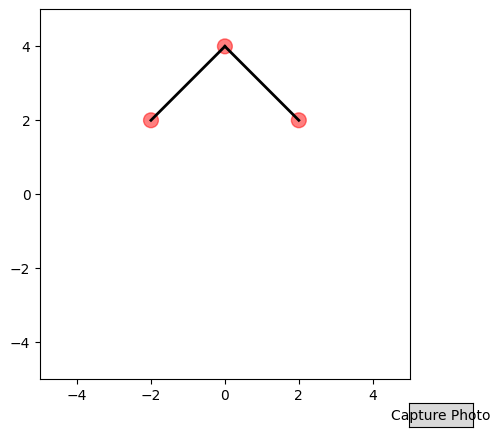

In [ ]:
# t5
!pip install mplcursors

# drf
import matplotlib.pyplot as plt
import mplcursors
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.widgets import Button

class PoseMannequin:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.set_xlim([-5, 5])
        self.ax.set_ylim([-5, 5])

        self.points = {'head': (0, 4), 'left_hand': (-2, 2), 'right_hand': (2, 2)}

        self.lines = []
        self.points_handles = {}

        self.init_mannequin()
        self.init_buttons()

    def init_mannequin(self):
        for limb in [('head', 'left_hand'), ('head', 'right_hand')]:
            line = Line2D([], [], linewidth=2, color='black')
            self.lines.append(line)
            self.ax.add_line(line)

        for point_name, point_coords in self.points.items():
            point_handle = Circle(point_coords, radius=0.2, color='red', alpha=0.5)
            self.points_handles[point_name] = point_handle
            self.ax.add_patch(point_handle)

        self.update_mannequin()

    def update_mannequin(self):
        for i, limb in enumerate([('head', 'left_hand'), ('head', 'right_hand')]):
            x = [self.points[limb[0]][0], self.points[limb[1]][0]]
            y = [self.points[limb[0]][1], self.points[limb[1]][1]]
            self.lines[i].set_data(x, y)

        for point_name, point_handle in self.points_handles.items():
            point_handle.center = self.points[point_name]

        self.fig.canvas.draw()

    def capture_photo(self, event):
        self.fig.savefig('mannequin_pose.png', dpi=300)
        print("Pose captured and saved as 'mannequin_pose.png'.")

    def on_point_move(self, sel):
        x, y, name = sel.target.index, sel.target.value, sel.artist.get_label()
        self.points[name] = (x, y)
        self.update_mannequin()

    def init_buttons(self):
        capture_button_ax = self.fig.add_axes([0.8, 0.01, 0.1, 0.05])
        capture_button = Button(capture_button_ax, 'Capture Photo')
        capture_button.on_clicked(self.capture_photo)

        mplcursors.cursor(hover=True).connect('add', self.on_point_move)

    def show(self):
        plt.show()

# Create a PoseMannequin instance
mannequin = PoseMannequin()

# Run the interactive display
mannequin.show()


In [ ]:
# @title DPM++ 2S a Karras

!pip install transformers

from transformers import AutoModelForCausalLM, AutoTokenizer

# Replace 'model_name' with the name of the desired model (e.g., 'openai/gpt2')
model_name = 'openai/gpt2'
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example usage
input_text = "Once upon a time"
input_ids = tokenizer.encode(input_text, return_tensors="pt")
output = model.generate(input_ids, max_length=50, num_beams=5, no_repeat_ngram_size=2)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

In [ ]:
# @title <b>Net Tools
!sudo apt-get install net-tools
!ifconfig

In [ ]:
# @title Google Vision module
!startx
!pip install google-cloud-vision
!pip install Pillow
!pip install tk
!sudo apt install apt-transport-https ca-certificates gnupg
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt cloud-sdk main" | sudo tee -a /etc/apt/sources.list.d/google-cloud-sdk.list
!sudo apt update && sudo apt upgrade -y
!sudo apt -y install -qq google-cloud-sdk

In [ ]:
# @title IMG_TXT
from google.cloud import vision_v1
from google.cloud.vision_v1 import types
from IPython.display import display, HTML
from google.colab import files

# Authenticate Google Cloud Vision API (Replace 'your_credentials.json' with your actual JSON key file)
!pip install google-cloud-vision
from google.colab import auth
auth.authenticate_user()

# Function to extract text from an image
def extract_text_from_image(image_path):
    client = vision_v1.ImageAnnotatorClient()

    with open(image_path, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    if texts:
        return texts[0].description
    else:
        return 'No text detected in the image.'

# Upload an image file
uploaded = files.upload()

# Assuming you uploaded an image named 'example.jpg'
image_path = list(uploaded.keys())[0]

# Extract text from the uploaded image
extracted_text = extract_text_from_image(image_path)

# Display the extracted text as a prompt
html_prompt = f'<div style="background-color: #f2f2f2; padding: 10px;"><b>Detected Text:</b><br>{extracted_text}</div>'
display(HTML(html_prompt))


In [ ]:
# @title <font color=yellow><b>Filter Guassiano Blur:4</b></font>
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Function to apply Gaussian filter with intensity 4
def apply_gaussian_filter(image_path, sigma=4):
    # Read the image
    image = cv2.imread(image_path)

    # Apply Gaussian filter
    filtered_image = cv2.GaussianBlur(image, (0, 0), sigma)

    return Image.fromarray(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))

# Upload an image file
uploaded = files.upload()

# Assuming you uploaded an image named 'example.jpg'
image_path = list(uploaded.keys())[0]

# Apply Gaussian filter with intensity 4
filtered_image = apply_gaussian_filter(image_path, sigma=4)

# Display the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.title('Filtered Image (Gaussian Blur, Sigma=4)')
plt.axis('off')

plt.show()



In [ ]:
# @title <b>IOSº SWITCHER ORIGINAL INTERACTIVE</b> <b><font color=cyan>2.6</font></b>
from IPython.display import HTML

ios_notepad_with_lion_and_time = """
<style>
  /* iOS background */
  .ios-background {
    position: relative;
    width: 300px;
    height: 600px;
    background-image: url('https://cdn.ipadizate.com/2019/04/ios-10-1.jpg');
    background-size: 100% 100%;
    border-radius: 20px;
    margin: 20px;
    padding: 20px;
    display: flex;
    flex-direction: column;
    align-items: center;
    justify-content: space-between;
    border: 5px solid #fff;
    animation: pulse 2s infinite;
  }

  @keyframes pulse {
    0%, 100% {
      border: 5px solid #fff;
    }
    50% {
      border: 5px solid #4CAF50;
    }
  }

  /* iOS Font */

  h1, h2, font {
    font-family: 'Arial', sans-serif;
    font-size: 16px;
    animation: textAnimation 5s infinite;
  }

  h2, font {
    font-family: inherit;
  }

  @keyframes textAnimation {
    0% {
      transform: scale(1);
    }
    50% {
      transform: scale(1.1);
    }
    100% {
      transform: scale(1);
    }
  }

  /* iOS battery */
  .battery {
    width: 80px;
    height: 30px;
    background-color: #eee;
    border: 2px solid #aaa;
    border-radius: 5px;
    margin-top: 10px;
  }

  /* Battery fill */
  .battery-fill {
    height: 100%;
    width: 60%;
    background-color: #4CAF50;
    border-radius: 3px;
  }

  /* iOS switch */
  .switch {
    position: absolute;
    top: 39%;
    left: 10%;
    width: 50px;
    height: 30px;
    margin-top: 110px;
  }

  .switch2 {
    position: absolute;
    top: 70%; /* Adjust the position as needed */
    left: 10%;
    width: 50px;
    height: 30px;
  }

  .switch3 {
    position: absolute;
    top: 63%; /* Adjust the position as needed */
    left: 10%;
    width: 50px;
    height: 30px;
  }

  .switch input {
    opacity: 0;
    width: 0;
    height: 0;
  }

  .slider {
    position: absolute;
    cursor: pointer;
    top: 0;
    left: 0;
    right: 0;
    bottom: 0;
    background-color: #d0e7c0;
    -webkit-transition: .4s;
    transition: .4s;
    border-radius: 15px;
  }

  .slider:before {
    position: absolute;
    content: "";
    height: 22px;
    width: 22px;
    left: 4px;
    bottom: 4px;
    background-color: white;
    -webkit-transition: .4s;
    transition: .4s;
    border-radius: 50%;
  }

  input:checked + .slider {
    background-color: #4CAF50;
  }

  input:checked + .slider:before {
    -webkit-transform: translateX(20px);
    -ms-transform: translateX(20px);
    transform: translateX(20px);
  }

  /* Writable notepad */
  .writable-notepad {
    position: absolute;
    width: 275px;
    height: 113px;
    background-color: rgba(255, 255, 255, 0.5);
    border-radius: 10px;
    box-shadow: 0 0 20px rgba(0, 0, 0, 0.5);
    backdrop-filter: blur(10px);
    bottom: 20px;
    display: flex;
    align-items: flex-end;
    padding: 20px;
    box-sizing: border-box;
  }

  .writable-notepad textarea {
    width: 100%;
    height: 90%;
    border-radius: 10px;
    background-color: rgba(65, 64, 64, 0.5);
    backdrop-filter: blur(10px);
    outline: none;
    resize: none;
    font-family: 'Arial', sans-serif;
    font-size: 14px;
    color: white;
  }

  /* Lion animation */
  .lion-animation {
    width: 80px;
    height: 80px;
    background-color: rgba(0, 0, 0, 0.0);
    border-radius: 50%;
    position: absolute;
    top: 60%;
    left: 60%;
    transform: translate(-50%, -50%);
    animation: bounce 2s infinite;
  }

  @keyframes bounce {
    0%, 20%, 50%, 80%, 100% {
      transform: translateY(0);
    }
    40% {
      transform: translateY(-30px);
    }
    60% {
      transform: translateY(-15px);
    }
  }

  /* Time display */
  .time-display {
    position: absolute;
    top: 10px;
    font-family: 'Arial', sans-serif;
    font-size: 18px;
    color: white;
  }

  /* Music player */
  .music-player {
    position: absolute;
    top: 10px;
    width: 80%;
    display: flex;
    justify-content: space-between;
  }

  .music-button {
    width: 30px;
    height: 30px;
    background-color: rgba(65, 64, 64, 0.5);
    border-radius: 50%;
    cursor: pointer;
    display: flex;
    align-items: center;
    justify-content: center;
  }

  .music-button.play:before {
    content: '\\25B6';
  }

  .music-button.pause:before {
    content: '\\II';
  }

  #imageInput {
    display: none;
  }

  /* YouTube screen */
  .youtube-screen {
    position: absolute;
    width: 275px;
    height: 140px;
    background-color: rgba(26, 0, 0, 0.7);
    border-radius: 10px;
    top: 100px;
    left: 50%;
    transform: translateX(-50%);
    overflow: hidden;
  }

  /* Red and black line animation */
  .youtube-screen .line {
    position: absolute;
    height: 2px;
    width: 0;
    background-color: red;
    transform-origin: left;
    animation: lineAnimation 2s infinite;
  }

  @keyframes lineAnimation {
    0%, 100% {
      width: 0;
      transform: scaleX(0);
    }
    50% {
      width: 100%;
      transform: scaleX(1);
    }
  }

  /* Rainbow text animation */
  @keyframes rainbowText {
    0% {
      color: #ff0000; /* Red */
    }
     10% {
      color: #ff7f00; /* Orange */
    }
     20% {
      color: #ffff00; /* Yellow */
    }
     30% {
      color: #00ff00; /* Green */
    }
     40% {
      color: #0000ff; /* Blue */
    }
     50% {
      color: #4b0082; /* Indigo */
    }
     60% {
      color: #9400d3; /* Violet */
    }
     70%, 100% {
      color: #ff0000; /* Red */
    }
  }

  /* Flash of random colors animation */
  @keyframes flashRandomColors {
    0% {
      background-color: rgba(255, 0, 0, 0.8); /* Red */
    }
    25% {
      background-color: rgba(0, 255, 0, 0.8); /* Green */
    }
    50% {
      background-color: rgba(0, 0, 255, 0.8); /* Blue */
    }
    75% {
      background-color: rgba(255, 255, 0, 0.8); /* Yellow */
    }
    100% {
      background-color: rgba(255, 0, 255, 0.8); /* Magenta */
    }
  }

</style>

<div class="ios-background" id="iosBackground">
  <div class="battery">
    <div class="battery-fill"></div>
  </div>
  <label class="switch">
    <input type="checkbox" onclick="toggleSwitch()">
    <span class="slider"></span>
  </label>
  <label class="switch2">
    <input type="checkbox" onclick="toggleSwitch2()">
    <span class="slider"></span>
  </label>
  <label class="switch3">
    <input type="checkbox" onclick="toggleSwitch()">
    <span class="slider"></span>
  </label>
  <div class="writable-notepad">
    <textarea id="noteTextarea" placeholder="Write your notes here..." oninput="updateLionAnimation(); animateRainbowText();"></textarea>
  </div>
  <div class="lion-animation" id="lionAnimation">
  <svg viewBox="0 0 22 28" xmlns="http://www.w3.org/2000/svg">
    <defs>
      <filter id="iosGaussian" x="0" y="0" width="%100" height="%100">
        <feGaussianBlur in="SourceGraphic" stdDeviation="3" />
      </filter>
    </defs>
    <path fill="rgba(255, 255, 255, 0.5)" opacity="1.0" width="%100" height="%100" viewBox="0 0 22 28" d="M21.766 18.984c-.391 1.234-1.016 2.547-1.922 3.906-1.344 2.047-2.688 3.063-4.016 3.063-.531 0-1.25-.172-2.188-.5-.922-.344-1.719-.5-2.359-.5-.625 0-1.375.172-2.219.516-.859.359-1.547.531-2.063.531-1.609 0-3.156-1.359-4.703-4.047C.78 19.265-.001 16.656-.001 14.094c0-2.391.594-4.328 1.766-5.844C2.937 6.75 4.406 6 6.203 6c.766 0 1.672.156 2.766.469 1.078.313 1.797.469 2.156.469.453 0 1.203-.172 2.234-.531 1.031-.344 1.937-.531 2.703-.531 1.25 0 2.359.344 3.328 1.016.547.375 1.094.906 1.625 1.563-.812.688-1.406 1.297-1.781 1.844a5.554 5.554 0 0 0-1.016 3.234c0 1.281.359 2.453 1.078 3.484s1.547 1.687 2.469 1.969zM15.891.656c0 .641-.156 1.359-.453 2.125-.313.781-.797 1.5-1.453 2.156-.562.562-1.125.938-1.687 1.125-.359.109-.891.203-1.625.266.031-1.547.438-2.891 1.219-4.016S13.986.421 15.798 0c.031.141.063.25.078.344 0 .109.016.203.016.313z" />
  </svg>
</div>
  <div class="time-display" id="timeDisplay"></div>
  <div class="music-player">
    <div class="music-button play" onclick="openImageInput()"></div>
    <div class="music-button pause" onclick="toggleMusic()"></div>
  </div>
  <input type="file" id="imageInput" accept="image/*" onchange="changeBackground(event)">
  <div class="youtube-screen" id="youtubeScreen">
    <div class="line"></div>
    <div id="youtubePlayer" style="display: none;"></div>
  </div>
</div>

<script>
  function updateTime() {
    var now = new Date();
    var hours = now.getHours().toString().padStart(2, '0');
    var minutes = now.getMinutes().toString().padStart(2, '0');
    var seconds = now.getSeconds().toString().padStart(2, '0');
    var timeString = hours + ':' + minutes + ':' + seconds;
    document.getElementById('timeDisplay').innerText = timeString;
  }

  function toggleMusic() {
    var playButton = document.querySelector('.music-button.play');
    var pauseButton = document.querySelector('.music-button.pause');

    playButton.classList.toggle('active');
    pauseButton.classList.toggle('active');
  }

  function updateLionAnimation() {
    var noteContent = document.getElementById('noteTextarea').value;
    var lionAnimation = document.getElementById('lionAnimation');
  }

  function toggleSwitch() {
    var iosBackground = document.getElementById('iosBackground');
    var switchInputs = document.querySelectorAll('.switch input');

    switchInputs.forEach(function(input) {
      if (input.checked) {
        iosBackground.style.backgroundImage = "url('https://i.pinimg.com/originals/4a/8f/9a/4a8f9a8ef0efff251245ff571f5bbd0d.gif')";
      } else {
        iosBackground.style.backgroundImage = "url('https://cdn.ipadizate.com/2019/04/ios-10-1.jpg')";
      }
    });
  }

  function toggleSwitch2() {
    var writableNotepad = document.querySelector('.writable-notepad');

    var switch2Input = document.querySelector('.switch2 input');

    if (switch2Input.checked) {
      // Enable .switch2: Flash of random colors
      writableNotepad.style.animation = 'flashRandomColors 1s infinite';
    } else {
      // Disable .switch2: Revert to original background-color
      writableNotepad.style.animation = 'none';
    }
  }

  function openImageInput() {
    document.getElementById('imageInput').click();
  }

  function changeBackground(event) {
    var iosBackground = document.getElementById('iosBackground');
    var file = event.target.files[0];

    if (file) {
      var reader = new FileReader();
      reader.onload = function (e) {
        iosBackground.style.backgroundImage = "url('" + e.target.result + "')";
      };
      reader.readAsDataURL(file);
    }
  }

  function playYouTubeVideo() {
    var youtubeScreen = document.getElementById('youtubeScreen');
    var youtubePlayer = document.getElementById('youtubePlayer');

    var videoUrl = 'https://www.youtube.com/watch?v=6yDSHC0EPyc';
    var videoId = videoUrl.split('v=')[1];

    youtubePlayer.innerHTML = '<iframe width="100%" height="100%" src="https://www.youtube.com/embed/' + videoId + '?autoplay=1" frameborder="0" allowfullscreen></iframe>';
    youtubePlayer.style.display = 'block';

    youtubeScreen.querySelector('.line').style.display = 'none';
  }

  function handlePauseButtonClick() {
    playYouTubeVideo();
    toggleMusic();
  }

  function toggleMusic() {
    var playButton = document.querySelector('.music-button.play');
    var pauseButton = document.querySelector('.music-button.pause');

    playButton.classList.toggle('active');
    pauseButton.classList.toggle('active');

    if (pauseButton.classList.contains('active')) {
      handlePauseButtonClick();
    }
  }

  var lineElement = document.querySelector('.youtube-screen .line');
  lineElement.style.top = 0;
  lineElement.style.bottom = 0;
  lineElement.style.left = 0;
  lineElement.style.right = 0;

  setInterval(updateTime, 1000);

  updateTime();

  // Function to animate rainbow text
  function animateRainbowText() {
    var textarea = document.getElementById('noteTextarea');
    textarea.style.animation = 'rainbowText 5s infinite';
  }
</script>
"""

HTML(ios_notepad_with_lion_and_time)

In [ ]:
# @title Texto de título predeterminado
from IPython.display import HTML, display

# HTML and JavaScript code for the iOS-style GUI with image editing tools
html_code = '''
<!DOCTYPE html>
<html>
<head>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/fabric.js/3.6.2/fabric.min.js"></script>
    <style>
        body {
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell,
                'Open Sans', 'Helvetica Neue', sans-serif;
            background-color: #f2f2f7;
            margin: 0;
            padding: 20px;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
            height: 100vh;
        }

        canvas {
            border: 1px solid #ddd;
        }

        .button {
            margin-top: 10px;
            padding: 10px 20px;
            font-size: 16px;
            background-color: #007aff;
            color: #ffffff;
            border: none;
            border-radius: 5px;
            cursor: pointer;
        }
    </style>
</head>
<body>
    <canvas id="imageCanvas" width="400" height="400"></canvas>

    <button class="button" onclick="applyFilter()">Apply Filter</button>

    <script>
        var canvas = new fabric.Canvas('imageCanvas');
        var imageUrl = 'https://placekitten.com/400/400';  // Replace with your image URL
        fabric.Image.fromURL(imageUrl, function(img) {
            canvas.add(img);
        });

        function applyFilter() {
            // Example filter: Grayscale
            var filter = new fabric.Image.filters.Grayscale();
            canvas.getActiveObject().filters.push(filter);
            canvas.getActiveObject().applyFilters(canvas.renderAll.bind(canvas));
        }
    </script>
</body>
</html>
'''

# Display the HTML code
display(HTML(html_code))

# Define the HTML and CSS for the green iOS switch
green_ios_switch = """
<style>
  .switch {
    position: relative;
    display: inline-block;
    width: 50px;
    height: 30px;
  }

  .switch input {
    opacity: 0;
    width: 0;
    height: 0;
  }

  .slider {
    position: absolute;
    cursor: pointer;
    top: 0;
    left: 0;
    right: 0;
    bottom: 0;
    background-color: #d0e7c0; /* Green background */
    -webkit-transition: .4s;
    transition: .4s;
    border-radius: 15px;
  }

  .slider:before {
    position: absolute;
    content: "";
    height: 22px;
    width: 22px;
    left: 4px;
    bottom: 4px;
    background-color: white;
    -webkit-transition: .4s;
    transition: .4s;
    border-radius: 50%;
  }

  input:checked + .slider {
    background-color: #4CAF50; /* Green when checked */
  }

  input:checked + .slider:before {
    -webkit-transform: translateX(20px);
    -ms-transform: translateX(20px);
    transform: translateX(20px);
  }
</style>

<label class="switch">
  <input type="checkbox">
  <span class="slider"></span>
</label>
"""

# Display the green iOS switch
HTML(green_ios_switch)


In [ ]:
# @title blur beta
!pip install ipywidgets

import cv2
import numpy as np
from PIL import Image
from ipywidgets import widgets, interact
from IPython.display import display

# Function to apply Gaussian blur to an image
def apply_gaussian_blur(image_path, blur_strength):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blurred_img = cv2.GaussianBlur(img, (blur_strength, blur_strength), 0)
    return Image.fromarray(blurred_img)

# Create widgets
image_button = widgets.FileUpload(description="Upload Image", accept=".jpg, .jpeg, .png")
blur_slider = widgets.IntSlider(value=1, min=1, max=50, description="Blur Strength")
save_button = widgets.Button(description="Save Image")

# Display widgets
display(image_button)
display(blur_slider)
display(save_button)

# Function to update the displayed image
def update_image(change):
    uploaded_image = list(image_button.value.values())[0]['content']
    image_path = 'uploaded_image.jpg'
    with open(image_path, 'wb') as f:
        f.write(uploaded_image)
    blurred_image = apply_gaussian_blur(image_path, blur_slider.value)
    display(blurred_image)

# Function to save the blurred image
def save_image(button):
    uploaded_image = list(image_button.value.values())[0]['content']
    image_path = 'uploaded_image.jpg'
    with open(image_path, 'wb') as f:
        f.write(uploaded_image)
    blurred_img = cv2.imread(image_path)
    blurred_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite('blurred_image.jpg', blurred_img)
    print("Image saved successfully!")

# Attach event handlers
image_button.observe(update_image, names='value')
interact(update_image, change=blur_slider)
save_button.on_click(save_image)


In [ ]:
# @title blur 55
from IPython.display import HTML, display
import cv2
import numpy as np
import ipywidgets as widgets

# Function to apply Gaussian blur to an image
def apply_blur(image_path, blur_strength):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blurred_img = cv2.GaussianBlur(img, (blur_strength, blur_strength), 0)
    return blurred_img

# Function to display the image
def display_image(image):
    image_widget.value = cv2.imencode('.png', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))[1].tobytes()

# Function to handle the apply button click event
def apply_button_click(change):
    blur_strength = blur_slider.value
    blurred_image = apply_blur('uploaded_image.jpg', blur_strength)
    display_image(blurred_image)

# Function to handle the download button click event
def download_button_click(change):
    blurred_image = apply_blur('uploaded_image.jpg', blur_slider.value)
    cv2.imwrite('blurred_image.jpg', cv2.cvtColor(blurred_image, cv2.COLOR_RGB2BGR))
    download_link.value = f'<a href="blurred_image.jpg" download>Download Image</a>'

# Function to handle the file upload event
def file_upload(change):
    uploaded_image = list(file_upload_widget.value.values())[0]['content']
    with open('uploaded_image.jpg', 'wb') as f:
        f.write(uploaded_image)
    image = cv2.imread('uploaded_image.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    display_image(image)

# Create widgets
file_upload_widget = widgets.FileUpload(accept=".jpg, .jpeg, .png")
apply_button = widgets.Button(description="Apply Blur")
download_button = widgets.Button(description="Download Image")
blur_slider = widgets.IntSlider(value=1, min=1, max=50, description="Blur Strength", continuous_update=False)
image_widget = widgets.Image(layout=widgets.Layout(width='512px', height='512px'))
download_link = widgets.HTML()

# Display widgets
file_upload_widget.observe(file_upload, names='value')
apply_button.on_click(apply_button_click)
download_button.on_click(download_button_click)
display(widgets.VBox([widgets.HBox([file_upload_widget, download_button]), blur_slider, apply_button, image_widget, download_link]))

# Initial display of the image
image_path = 'path_to_default_image.jpg'  # Replace with the path to your default image
default_image = cv2.imread(image_path)
default_image = cv2.cvtColor(default_image, cv2.COLOR_BGR2RGB)
display_image(default_image)


In [ ]:
#!/bin/bash

# Download resources.tar.gz
!curl "https://raw.githubusercontent.com/dailystudio/ml/master/deeplab/app/src/main/assets/deeplabv3_257_mv_gpu.tflite" -o resources.tar.gz

# Extract the contents of resources.tar.gz
!tar -xf resources.tar.gz
!tar -zxvf resources.tar.gz

# Remove the downloaded resources.tar.gz
!rm resources.tar.gz

!pip install tensorflow-serving-api

!pip install tflite


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2714k  100 2714k    0     0  4204k      0 --:--:-- --:--:-- --:--:-- 4207k

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [11]:
%%bash
apt-get install -y aria2
pip install bpytop


Reading package lists...
Building dependency tree...
Reading state information...
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [13]:
import subprocess

class TorrentDownloader:
    def __init__(self):
        self.file_path = None

    def select_torrent(self):
        self.file_path = input("Enter the path to the .torrent file: ")

    def start_download(self):
        if self.file_path:
            save_path = input("Enter the destination directory: ")
            cmd = f"aria2c -d '{save_path}' '{self.file_path}'"
            subprocess.run(cmd, shell=True)
            print("Download completed!")
        else:
            print("Select a .torrent file first.")

    def main(self):
        while True:
            print("Torrent Downloader")
            print("1. Select .torrent file")
            print("2. Start Download")
            print("3. Quit")

            choice = input("Enter your choice: ")

            if choice == '1':
                self.select_torrent()
            elif choice == '2':
                self.start_download()
            elif choice == '3':
                break
            else:
                print("Invalid choice. Try again.")

if __name__ == "__main__":
    downloader = TorrentDownloader()
    downloader.main()


Torrent Downloader
1. Select .torrent file
2. Start Download
3. Quit
Enter your choice: fvkdvdvñv
Invalid choice. Try again.
Torrent Downloader
1. Select .torrent file
2. Start Download
3. Quit
Enter your choice: 1
Enter the path to the .torrent file: /content/3.torrent
Torrent Downloader
1. Select .torrent file
2. Start Download
3. Quit
Enter your choice: 2
Enter the destination directory: /content/


KeyboardInterrupt: ignored

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title IA BLUR
from google.colab import files
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import cv2
import numpy as np
from PIL import Image
from io import BytesIO

# Load pre-trained DeepLabv3 model
model_path = '/content/deeplabv3_mnv2_pascal_trainval/frozen_inference_graph.pb'  # Replace with the actual path
model = cv2.dnn.readNetFromTensorflow(model_path)

# Function to apply blur to image background
def apply_blur(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match DeepLabv3 input size (257x257)
    img = cv2.resize(img, (257, 257))

    # Normalize the image
    input_blob = cv2.dnn.blobFromImage(img, 1.0 / 127.5, (127.5, 127.5, 127.5), swapRB=True, crop=False)

    # Set the input to the model
    model.setInput(input_blob)

    # Run the model
    output = model.forward()

    # Get the segmentation mask
    mask = output[0, 15, :, :]  # Assuming the class index for the background is 15
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Apply blur to the background
    blurred_img = cv2.GaussianBlur(img, (15, 15), 0)
    result_img = np.where(np.expand_dims(mask, axis=-1) > 0, img, blurred_img)

    return Image.fromarray(result_img)

# Function to handle file upload
def handle_upload(change):
    uploaded_file = list(file_upload_widget.value.values())[0]
    img = Image.open(BytesIO(uploaded_file['content']))
    img_path = 'uploaded_image.jpg'
    img.save(img_path)

    # Display the uploaded image
    display(widgets.Image(value=uploaded_file['content']))

# Function to handle the button click
def generate_image_button_click(b):
    # Apply blur and display the images
    result_img = apply_blur('uploaded_image.jpg')

    clear_output(wait=True)
    display(widgets.VBox([file_upload_widget, generate_image_button, widgets.Image(value=result_img.tobytes())]))

# Create file upload widget
file_upload_widget = widgets.FileUpload()
file_upload_widget.observe(handle_upload, names='value')

# Create generate image button
generate_image_button = widgets.Button(description="Generate Blurred Image")
generate_image_button.on_click(generate_image_button_click)

# Display the GUI
display(widgets.VBox([file_upload_widget, generate_image_button]))


error: ignored

In [ ]:
# @markdown Generate in GUI
count_runs = 0
generate_img("")

In [ ]:
# @markdown Display the most recently saved generated image.
count_runs = 0
for i in image_list:
    mediapy.show_images([Image.open(i)])

In [ ]:
#@title Codeformer: Upscale and face restoration { form-width: "20%", display-mode: "form" }
from IPython.utils import capture
import os
import shutil
count_runs = 0

%cd /content
directory_codeformer = '/content/CodeFormer/'
with capture.capture_output() as cap:
  if not os.path.exists(directory_codeformer):
      os.makedirs(directory_codeformer)

      # Setup
      # Clone CodeFormer and enter the CodeFormer folder
      %cd /content
      !git clone https://github.com/sczhou/CodeFormer.git
      %cd CodeFormer


      # Set up the environment
      # Install python dependencies
      !pip install -q -r requirements.txt
      !pip -q install ffmpeg
      # Install basicsr
      !python basicsr/setup.py develop

      # Download the pre-trained model
      !python scripts/download_pretrained_models.py facelib
      !python scripts/download_pretrained_models.py CodeFormer
  del cap
# Visualization function
import cv2
import matplotlib.pyplot as plt
def display_codeformer(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('CodeFormer', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Copy imgs
Select_an_image = "" # @param {type:"string"}

# PROCESS AD
if os.path.exists(Select_an_image.strip()):
    image_list = [Select_an_image.replace('/content/', '').strip()]

destination_directory = '/content/CodeFormer/inputs/user_upload'
!rm -rf /content/CodeFormer/inputs/user_upload/*
os.makedirs(destination_directory, exist_ok=True)
for image_path in image_list:
    image_filename = os.path.basename('/content/'+image_path)
    destination_path = os.path.join(destination_directory, image_filename)
    try:
        shutil.copyfile('/content/'+image_path, destination_path)
        print(f"Image '{image_filename}' has been copied to '{destination_path}'")
    except Exception as e:
        print(f"Failed to copy '{image_filename}' to '{destination_path}': {e}")

#@markdown `CODEFORMER_FIDELITY`: Balance the quality (lower number) and fidelity (higher number)<br>
# you can add '--bg_upsampler realesrgan' to enhance the background
CODEFORMER_FIDELITY = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown `BACKGROUND_ENHANCE`: Enhance background image with Real-ESRGAN<br>
BACKGROUND_ENHANCE = False #@param {type:"boolean"}
#@markdown `FACE_UPSAMPLE`: Upsample restored faces for high-resolution AI-created images<br>
FACE_UPSAMPLE = True #@param {type:"boolean"}
#markdown `HAS_ALIGNED`: Input are cropped and aligned faces<br>
HAS_ALIGNED =  False
#@markdown `UPSCALE`: The final upsampling scale of the image. Default: 2<br>
UPSCALE = 1 #@param {type:"slider", min:1, max:8, step:1}
#markdown `DETECTION_MODEL`: Face detector. Default: retinaface_resnet50<br>
DETECTION_MODEL = "retinaface_resnet50"
#markdown `DRAW_BOX`: Draw the bounding box for the detected faces.
DRAW_BOX = False

BACKGROUND_ENHANCE = '--bg_upsampler realesrgan' if BACKGROUND_ENHANCE else ''
FACE_UPSAMPLE = '--face_upsample' if FACE_UPSAMPLE else ''
HAS_ALIGNED = '--has_aligned' if HAS_ALIGNED else ''
DRAW_BOX = '--draw_box' if DRAW_BOX else ''
%cd CodeFormer
!python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path {destination_directory} {BACKGROUND_ENHANCE} {FACE_UPSAMPLE} {HAS_ALIGNED} --upscale {UPSCALE} --detection_model {DETECTION_MODEL} {DRAW_BOX}


import os
import glob

input_folder = 'inputs/user_upload'
result_folder = f'results/user_upload_{CODEFORMER_FIDELITY}/final_results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  basename = os.path.splitext(os.path.basename(input_path))[0]
  output_path = os.path.join(result_folder, basename+'.png')
  img_output = imread(output_path)
  display_codeformer(img_input, img_output)

%cd /content

Upscale results in /content/CodeFormer/results


In [ ]:
#@title Download Images
import os
from google.colab import files
!rm /content/results.zip
!ls /content/images
print('Download results')
os.system(f'zip -r results.zip /content/images')
try:
  files.download("results.zip")
except:
  print("Error")

In [ ]:
#@title Download Upscale results
import os
from google.colab import files
import shutil
%cd /content/CodeFormer
!ls results
print('Download results')
os.system(f'zip -r results.zip results/user_upload_{CODEFORMER_FIDELITY}/final_results')
try:
  files.download("results.zip")
except:
  files.download(f'/content/CodeFormer/results/{filename[:-4]}_{CODEFORMER_FIDELITY}/{filename}')
%cd /content

# Extras for advanced users

In [ ]:
# You can also use this cell to simply reload the model in case you need to.
del model

In [ ]:
# If the generate button is disabled
generate.disabled = False

In [ ]:
# If you encounter a problem with "Out Of Memory," you can click on this cell and rerun cells 2 and 3.
import os
os.kill(os.getpid(), 9)

In [ ]:
# @title Alternative generation
# @markdown Sometimes the GUI gets stuck when multiple operations are run. Once the GUI is loaded, you can use this cell to generate images here as an alternative.

count_runs = 0
def generate_img_beta():
    global model

    # First load
    try:
        model
    except:
        model = Model_Diffusers(base_model_id=select_model.value, task_name=select_task.value, vae_model = vae_model_dropdown.value, type_model_precision = model_precision.value)
        print("Loading model...")

    model.load_pipe(select_model.value, task_name=select_task.value, vae_model = vae_model_dropdown.value, type_model_precision = model_precision.value)

    try:
      preprocessor_name_found = int_inputs[select_task.value][0].value
    except:
      preprocessor_name_found = None

    global destination_path_cn_img, mask_control, image_list, count_runs

    image_control_base = None
    if select_task.value != control_model_list[13]:
        try:
            image_control_base = destination_path_cn_img
        except:
            print("No control image found")
            generate.disabled = False
            return

    mask_control_base = None
    if select_task.value == control_model_list[12]:
        if os.path.exists(int_inputs[control_model_list[12]][1].value):
            mask_control_base = int_inputs[control_model_list[12]][1].value
        else:
            try:
                mask_control_base = mask_control
            except:
                print("No mask image found")
                generate.disabled = False
                return


    if upscaler_model_path_gui.value in [None, "Lanczos", "Nearest"]:
        upscaler_model = upscaler_model_path_gui.value
    else:
        directory_upscalers = 'upscalers'
        os.makedirs(directory_upscalers, exist_ok=True)

        url_upscaler = upscaler_dict_gui[upscaler_model_path_gui.value]

        if not os.path.exists(f"./upscalers/{url_upscaler.split('/')[-1]}"):
            download_things(directory_upscalers, url_upscaler, hf_token)

        upscaler_model = f"./upscalers/{url_upscaler.split('/')[-1]}"

    logging.getLogger("ultralytics").setLevel(logging.INFO if adetailer_verbose.value else logging.ERROR)

    adetailer_params_A = {
        "face_detector_ad" : face_detector_ad_A.value,
        "person_detector_ad" : person_detector_ad_A.value,
        "hand_detector_ad" : hand_detector_ad_A.value,
        "prompt": prompt_ad_A.value,
        "negative_prompt" : negative_prompt_ad_A.value,
        "strength" : strength_ad_A.value,
        # "image_list_task" : None,
        "mask_dilation" : mask_dilation_A.value,
        "mask_blur" : mask_blur_A.value,
        "mask_padding" : mask_padding_A.value,
        "inpaint_only" : adetailer_inpaint_only.value,
        "sampler" : adetailer_sampler.value,
    }

    adetailer_params_B = {
        "face_detector_ad" : face_detector_ad_B.value,
        "person_detector_ad" : person_detector_ad_B.value,
        "hand_detector_ad" : hand_detector_ad_B.value,
        "prompt": prompt_ad_B.value,
        "negative_prompt" : negative_prompt_ad_B.value,
        "strength" : strength_ad_B.value,
        # "image_list_task" : None,
        "mask_dilation" : mask_dilation_B.value,
        "mask_blur" : mask_blur_B.value,
        "mask_padding" : mask_padding_B.value,
    }
    pipe_params = {
    "prompt": prompt.value,
    "negative_prompt": neg_prompt.value,
    "img_height": img_height.value,
    "img_width": img_width.value,
    "num_images": num_images.value,
    "num_steps": steps.value,
    "guidance_scale": CFG.value,
    "clip_skip": select_clip_skip.value,
    "seed": random_seed.value,
    "image": image_control_base,
    "preprocessor_name": preprocessor_name_found,
    "preprocess_resolution": preprocess_resolution_global.value,
    "image_resolution": image_resolution_global.value,
    "style_prompt": style_names_multi_selection.value,
    "style_json_file" : "",
    "image_mask": mask_control_base, # only for Inpaint
    "strength": int_inputs[control_model_list[12]][0].value, # only for Inpaint
    "low_threshold": int_inputs[control_model_list[1]][0].value,
    "high_threshold": int_inputs[control_model_list[1]][1].value,
    "value_threshold": int_inputs[control_model_list[2]][0].value,
    "distance_threshold": int_inputs[control_model_list[2]][1].value,
    "lora_A": select_lora1.value,
    "lora_scale_A": lora_weights_scale1.value,
    "lora_B": select_lora2.value,
    "lora_scale_B": lora_weights_scale2.value,
    "lora_C": select_lora3.value,
    "lora_scale_C": lora_weights_scale3.value,
    "lora_D": select_lora4.value,
    "lora_scale_D": lora_weights_scale4.value,
    "lora_E": select_lora5.value,
    "lora_scale_E": lora_weights_scale5.value,
    "textual_inversion": embed_list if active_ti.value else [],
    "syntax_weights" : weights_prompt.value, #"Classic" , #"convert_weights_prompt": weights_prompt.value,
    "sampler": select_sampler.value,
    "xformers_memory_efficient_attention": xformers_memory_efficient_attention.value,
    "gui_active": True,
    "loop_generation": loop_generator.value,
    "controlnet_conditioning_scale" : controlnet_output_scaling_in_unet.value,
    "control_guidance_start" : controlnet_start_threshold.value,
    "control_guidance_end" : controlnet_stop_threshold.value,
    "generator_in_cpu" : init_generator_in_cpu.value,
    "FreeU" : freeu_check.value,
    "adetailer_A" : adetailer_active_A.value,
    "adetailer_A_params" : adetailer_params_A,
    "adetailer_B" : adetailer_active_B.value,
    "adetailer_B_params" : adetailer_params_B,
    "leave_progress_bar" : True,
    "disable_progress_bar" : disable_progress_bar_check.value,
    "image_previews" : False,
    "display_images" : display_images.value,
    "save_generated_images" : save_generated_images.value,
    "image_storage_location" : image_directory.value,
    "retain_compel_previous_load" : retain_compel_previous_load.value,
    "retain_detailfix_model_previous_load": retain_detailfix_model_previous_load.value,
    "retain_hires_model_previous_load": retain_hires_model_previous_load.value,
    "t2i_adapter_preprocessor" : t2i_adapter_preprocessor_check.value,
    "t2i_adapter_conditioning_scale" : adapter_conditioning_scale_scale.value,
    "t2i_adapter_conditioning_factor" : adapter_conditioning_factor_fraction.value,
    "upscaler_model_path" : upscaler_model,
    "upscaler_increases_size" : upscaler_increases_size.value,
    "esrgan_tile" : esrgan_tile.value,
    "esrgan_tile_overlap" : esrgan_tile_overlap.value,
    "hires_steps" : hires_steps.value,
    "hires_denoising_strength" : hires_denoising_strength.value,
    "hires_prompt" : hires_prompt.value,
    "hires_negative_prompt" : hires_negative_prompt.value,
    "hires_sampler" : hires_sampler.value,
    "hires_before_adetailer" : hires_before_adetailer.value,
    "hires_after_adetailer" : hires_after_adetailer.value
    }

    #print(pipe_params)

    images, image_list = model(**pipe_params)

    torch.cuda.empty_cache()
    gc.collect()

    return

generate_img_beta()

In [ ]:
import os
from huggingface_hub import HfApi
import tempfile
from typing import Optional, Union
import random
import string
count_runs = 0

#@title Submit the images to your Hugging Face repository (Need an account on Hugging Face) { form-width: "20%", display-mode: "form" }
#@markdown Basically, this allows you to use a repository on Hugging Face to store whatever you want. In this case, we want to use the repository to store our generated images

#@markdown ---
#@markdown **Specify the folder of the images you will upload and the destination folder in the repository**
folder_in_notebook = "images" # @param {type:"string"}
folder_in_repo = "images_24_11_23" # @param {type:"string"}
#@markdown ---
#@markdown **Select the destination repository from your account; if it doesn't exist, it will be created. Example: `your_username/random_name_repo`**
repo_id = "" # @param {type:"string"}
private_repo = True # @param {type:"boolean"}
#@markdown **To be able to use your repository, you need a token with write permissions. You can get it here: https://huggingface.co/settings/tokens.**
token = "" # @param {type:"string"}

api = HfApi()
api.create_repo(
    repo_id = repo_id,
    repo_type = "dataset",
    private = private_repo,
    exist_ok = True,
    token = token,
)

api.upload_folder(
    folder_path=folder_in_notebook,
    path_in_repo=folder_in_repo,
    repo_id=repo_id,
    token= token,
    repo_type="dataset",
    #ignore_patterns="**/logs/*.txt",
)

print(f"https://huggingface.co/datasets/{repo_id}/tree/main/{folder_in_repo}")

In [ ]:
# @title Select a style file for the loaded model
import os

style_file = "sdxl_styles" # @param ["sdxl_styles", "sdxl_styles_sai", "sdxl_styles_twri"] {type:"string"}

styles_dict_p = {
    "sdxl_styles" : "https://raw.githubusercontent.com/ahgsql/StyleSelectorXL/main/sdxl_styles.json",
    "sdxl_styles_sai" : "https://raw.githubusercontent.com/twri/sdxl_prompt_styler/main/sdxl_styles_sai.json",
    "sdxl_styles_twri" : "https://raw.githubusercontent.com/twri/sdxl_prompt_styler/main/sdxl_styles_twri.json",
}

url = styles_dict_p[style_file]
!wget {url} -q

model.load_style_file(os.path.basename(url))
style_names_multi_selection.options = model.STYLE_NAMES
print("New styles set in the GUI")

In [ ]:
# @markdown #### or submit and load a style file in the model (json format) [PromptStylers](https://github.com/wolfden/ComfyUi_PromptStylers), [sdxl_prompt_styler](https://github.com/ali1234/sdxl_prompt_styler/tree/main)
from google.colab import files

uploaded = files.upload()
file_names = list(uploaded.keys())

if file_names[0].endswith('.json'):
    model.load_style_file(file_names[0])
    style_names_multi_selection.options = model.STYLE_NAMES
    print("New styles set in the GUI")
else:
    print("Error: Need a json file")

In [ ]:
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy import UpscalerESRGAN
import os
from PIL import Image
count_runs = 0

upscaler_dict = {
    "RealESRGAN_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth",
    "RealESRNet_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.1/RealESRNet_x4plus.pth",
    "RealESRGAN_x4plus_anime_6B": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth",
    "RealESRGAN_x2plus": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth",
    "realesr-animevideov3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-animevideov3.pth",
    "realesr-general-x4v3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth",
    "realesr-general-wdn-x4v3" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-wdn-x4v3.pth",
    "4x-UltraSharp" : "https://huggingface.co/Shandypur/ESRGAN-4x-UltraSharp/resolve/main/4x-UltraSharp.pth",
    "4x_foolhardy_Remacri" : "https://huggingface.co/FacehugmanIII/4x_foolhardy_Remacri/resolve/main/4x_foolhardy_Remacri.pth",
    "Remacri4xExtraSmoother" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/Remacri%204x%20ExtraSmoother.pth",
    "AnimeSharp4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/AnimeSharp%204x.pth",
    "lollypop" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/lollypop.pth",
    "RealisticRescaler4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/RealisticRescaler%204x.pth",
    "NickelbackFS4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/NickelbackFS%204x.pth"
}

#@markdown # Alternative Upscaler Tool
#@markdown You can leave `Select_an_image` blank to process the last generated images.
Select_an_image = "" # @param {type:"string"}
MODEL_UPSCALER = "RealESRGAN_x4plus_anime_6B" #@param ["RealESRGAN_x4plus", "RealESRNet_x4plus", "RealESRGAN_x2plus", "RealESRGAN_x4plus_anime_6B", "realesr-animevideov3", "realesr-general-x4v3", "realesr-general-wdn-x4v3", "4x-UltraSharp", "4x_foolhardy_Remacri", "Remacri4xExtraSmoother", "AnimeSharp4x", "lollypop", "RealisticRescaler4x", "NickelbackFS4x"]
Scale_of_the_image_x = 1.5 #@param {type:"slider", min:1, max:4, step:0.5}
show_result = True #@param {type: "boolean"}

directory_upscalers = 'upscalers'
os.makedirs(directory_upscalers, exist_ok=True)

url_upscaler = upscaler_dict[MODEL_UPSCALER]

if not os.path.exists(f"./upscalers/{url_upscaler.split('/')[-1]}"):
    download_things(directory_upscalers, url_upscaler, hf_token)

scaler_beta = UpscalerESRGAN()

if os.path.exists(Select_an_image.strip()):
    image_list = [Select_an_image.replace('/content/', '').strip()]

for img_base in image_list:
    img_pil = Image.open(img_base)
    img_up = scaler_beta.upscale(img_pil, Scale_of_the_image_x , f"./upscalers/{url_upscaler.split('/')[-1]}")

    if show_result:
        display(img_up)

    image_path = save_pil_image_with_metadata(img_up, f'{os.getcwd()}/up_images', metadata_list=None)
    print(image_path)

In [ ]:
from PIL import Image
import os, torch, gc
count_runs = 0
from stablepy.diffusers_vanilla.adetailer import ad_model_process
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy.diffusers_vanilla.extra_model_loaders import custom_task_model_loader

torch.cuda.empty_cache()
gc.collect()

detailfix_pipe = custom_task_model_loader(
    pipe=model.pipe,
    model_category="detailfix", # inpaint_only = True
    task_name=select_task.label,
    torch_dtype=model_precision.value
)
detailfix_pipe.to("cuda" if torch.cuda.is_available() else "cpu")
# same scheduler as base pipe

# OPTIONS #
# @markdown # Adetailer (inpaint only)
# @markdown This will use the parameters and the loaded model of the GUI.
Select_an_image = "" # @param {type:"string"}
prompt_ad = "masterpiece, best quality, extremely detailed wallpaper" # @param {type:"string"}
negative_prompt_ad = "worst quality, normal quality, low quality, low res, blurry, text, watermark, logo, banner, extra digits, cropped, jpeg artifacts, signature, username, error, sketch ,duplicate, ugly, monochrome, horror, geometry, mutation, disgusting" # @param {type:"string"}
strength_ad = 0.4 # @param {type:"number"}
face_detector_ad = True # @param {type:"boolean"}
person_detector_ad = True # @param {type:"boolean"}
hand_detector_ad = False # @param {type:"boolean"}
mask_dilation = 4 # @param {type:"integer"}
mask_blur = 4 # @param {type:"integer"}
mask_padding = 32 # @param {type:"integer"}

detailfix_params__ = {
    "prompt": prompt_ad,
    "negative_prompt" : negative_prompt_ad,
    "strength" : strength_ad,
    "num_inference_steps": steps.value,
    "guidance_scale" : CFG.value,
}
adetailer_params__ = {
    "face_detector_ad" : face_detector_ad,
    "person_detector_ad" : person_detector_ad,
    "hand_detector_ad" : hand_detector_ad,
    #"inpaint_only" : True,
    # "image_list_task" : None,
    "mask_dilation" : mask_dilation,
    "mask_blur" : mask_blur,
    "mask_padding" : mask_padding,
}

# PROCESS AD
if os.path.exists(Select_an_image):
    image_list = [Select_an_image]

image_pil_list = []
for path in image_list:
    if os.path.exists(path):
        # Open the image using PIL and convert it to PIL.Image.Image
        with Image.open(path) as img:
            image_ad = img.convert("RGB")
            image_pil_list.append(image_ad)

ad_pil_list = ad_model_process(
    pipe_params_df=detailfix_params__,
    detailfix_pipe=detailfix_pipe,
    image_list_task=image_pil_list,
    **adetailer_params__,
)

for img_ad in ad_pil_list:
    display(img_ad)
    image_path = save_pil_image_with_metadata(img_ad, f'{os.getcwd()}/images', metadata_list=None)
    print(image_path)

del detailfix_pipe
torch.cuda.empty_cache()
gc.collect()
print("")

In [ ]:
# @markdown CONVERT SAFETENSORS TO DIFFUSERS for SD 1.5
path_safetensor_model = "" # @param {type:"string"}
path_diffusers_model = "./converted_model/" # @param {type:"string"}

from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_single_file(path_safetensor_model).to("cuda")
pipe.save_pretrained(path_diffusers_model) # model path inpaint is ./adetailer_model/
del pipe
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from stablepy import logger
Verbosity_Level = "INFO" # @param ["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"]
import logging, warnings, diffusers

logging_level_mapping = {
    'DEBUG': logging.DEBUG,
    'INFO': logging.INFO,
    'WARNING': logging.WARNING,
    'ERROR': logging.ERROR,
    'CRITICAL': logging.CRITICAL
}

if Verbosity_Level != "DEBUG":
    logging.getLogger("diffusers").setLevel(logging.ERROR)
    diffusers.utils.logging.set_verbosity(40)
    #warnings.resetwarnings()
    warnings.filterwarnings(action="ignore", category=FutureWarning, module="diffusers")
    warnings.filterwarnings(action="ignore", category=UserWarning, module="diffusers")
else:
    logging.getLogger("diffusers").setLevel(logging.INFO)
    diffusers.utils.logging.set_verbosity(30)
    warnings.filterwarnings(action="default", category=FutureWarning, module="diffusers")
    warnings.filterwarnings(action="default", category=UserWarning, module="diffusers")

logger.setLevel(logging_level_mapping.get(Verbosity_Level, logging.NOTSET))

Utility:

Convert [SDXL TO DIFFUSERS](https://github.com/Linaqruf/sdxl-model-converter)

If you are a mobile user, you can use this [space](https://huggingface.co/spaces/r3gm/inpaint-mask-maker) to create the mask for the inpaint. After that, you have to upload the mask image, specify its path in the GUI, and then upload your original image.

In the GUI, the 'save_and_load_config' check saves all the parameters used in the last generation. If you run the cell again, it will reload the same parameters in the GUI so that you don't have to input them again, except for the 'adetailer' tab."